In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
from scipy import stats
from tqdm import tnrange, tqdm_notebook

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
sns.set_style("whitegrid")

In [2]:
# Get all knockdown expts and controls
manifest_directory = '/projects/ps-yeolab3/encode/'
k562 = pd.read_table(os.path.join(
    manifest_directory,
    'k562_brenton-graveley_ambiguous_bams_for_integrated_analysis.txt'
), index_col=0)
hepg2 = pd.read_table(os.path.join(
    manifest_directory,
    'hepg2_brenton-graveley_ambiguous_bams_for_integrated_analysis.txt'
), index_col=0)

manifest = pd.concat([k562, hepg2])
manifest.head()

control_rep1               control_rep1_md5sum  \
ENCSR000KYM  ENCFF309OOI.bam  006834b1e534abfc0a766464ce4f60d9   
ENCSR000YYN  ENCFF848JJM.bam  c04240081b7bb137e69d298837baa648   
ENCSR004RGI  ENCFF178NNK.bam  7b1be9be800298f9f8958b2adc14090c   
ENCSR007XKL  ENCFF985IXD.bam  2e7f51c61c5c545dfba6906772ac5716   
ENCSR023HWI  ENCFF804JHE.bam  f14e222eebd2030a3da0d086acd48bf7   

                control_rep2               control_rep2_md5sum  \
ENCSR000KYM  ENCFF209PLP.bam  b50208a4553de637758e93ceaa099569   
ENCSR000YYN  ENCFF695KEA.bam  14e5ef8ccef0d53859e5f67375f4c13f   
ENCSR004RGI  ENCFF098BEA.bam  d3be652a5058aacf2e9d95311bcba657   
ENCSR007XKL  ENCFF461TSD.bam  9e3ce9878e3352b44855f4a2d1c66d37   
ENCSR023HWI  ENCFF819ORB.bam  14d4a76c9237f92eff0e40f19ef4ffcb   

                   expt_rep1                  expt_rep1_md5sum  \
ENCSR000KYM  ENCFF354JPP.bam  aa41d43a1f51b87c0691d0526f4f3ac5   
ENCSR000YYN  ENCFF640HPA.bam  7f4e51a76b95e8699789d5bb36c5df85   
ENCSR004RGI  ENCFF922IOC.bam  a2588d2a5a56edeb4f96ea6f4c17d4d9   
ENCSR007XKL  ENCFF878JKR.bam  4ee27925a7f0f3ce95964686da0a8927   
ENCSR023HWI  ENCFF656QEN.bam  f409a646dd82e6b47c88869cd1921a55   

                   expt_rep2                  expt_rep2_md5sum     name  
ENCSR000KYM  ENCFF243AMZ.bam  dea667416a4d4c3c582637c2f9ad0f19    DDX3X  
ENCSR000YYN  ENCFF065KHB.bam  84a492145ce5bf8f806aa2b7f9b30765    AKAP8  
ENCSR004RGI  ENCFF459YMO.bam  22e6c3066888702577d180c635d0280b    RPS10  
ENCSR007XKL  ENCFF466OZP.bam  c69b58950871a86055b9f24744add8c6     NFX1  
ENCSR023HWI  ENCFF738SSD.bam  83fe79368dde05a9405107b333b0eca3  KHDRBS1

In [3]:
def get_avg(row):
    n1 = row['dpsi_x']
    n2 = row['dpsi_y']
    if np.isnan(n1):
        return n2
    elif np.isnan(n2):
        return n1
    else:
        return (n1 + n2) / 2.0
    
def get_avg_dpsi(files):
    names = ['exc_count', 'inc_count', 'dpsi']
    df1 = pd.read_table(files[0], sep='\t', index_col=0, names=names).drop_duplicates()
    df2 = pd.read_table(files[1], sep='\t', index_col=0, names=names).drop_duplicates()
    merged = pd.merge(df1, df2, how='outer', left_index=True, right_index=True)
    merged['avg'] = merged.apply(get_avg, axis=1)
    return merged['avg']

def get_all_required_files(expt_id, jxc_dir, df=manifest):
    """
    For each experiment ID, return: distributions of 
    the average dpsi vals for both reps for each condition
    """
    sub = df.ix[expt_id]
    prefix = '.primary.namesort.bam.CIandRI.psi'
    expt_files = [
        os.path.join(jxc_dir, (sub['expt_rep1'] + prefix)), 
        os.path.join(jxc_dir, (sub['expt_rep2'] + prefix))
    ]
    ctrl_files = [
        os.path.join(jxc_dir, (sub['control_rep1'] + prefix)), 
        os.path.join(jxc_dir, (sub['control_rep2'] + prefix))
    ]
    kd_avg_dpsi = get_avg_dpsi(expt_files)
    ctrl_avg_dpsi = get_avg_dpsi(ctrl_files)
    return kd_avg_dpsi, ctrl_avg_dpsi
    
#eCDF

colors = sns.color_palette("hls", 8)

def plot_cdf(expt, ctrl, output_file):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5,7.5))

    num_bins = 100
    n, bins, patches = plt.hist(
        ctrl, 
        normed=True, 
        cumulative=True, 
        histtype='step', 
        color=colors[0], 
        bins=num_bins, 
        alpha=0
    )
    ax.plot(bins[1:], n, color=colors[0], label='ctrl')
    #eCDF

    num_bins = 100
    n, bins, patches = plt.hist(
        expt, 
        normed=True, 
        cumulative=True, 
        histtype='step', 
        color=colors[5], 
        bins=num_bins, 
        alpha=0
    )
    ax.plot(bins[1:], n, color=colors[5], label='expt')
    ax.legend()
    fig.savefig(out_file)

/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ENCSR000SKS
ENCSR003LSA
ENCSR004OSI
ENCSR009PPI
ENCSR010ZMZ
ENCSR011BBS
ENCSR012DAF
ENCSR016IDR
ENCSR016XPB
ENCSR028ITN
ENCSR028YAQ
ENCSR030ARO
ENCSR030GZQ
ENCSR040WAK
ENCSR047VPW
ENCSR052IYH
ENCSR057GCF
ENCSR060IWW
ENCSR064DXG
ENCSR070LJO
ENCSR074UZM
ENCSR081IAO
ENCSR081QQH
ENCSR090UMI
ENCSR094KBY
ENCSR104OLN
ENCSR105OXX
ENCSR110HAA
ENCSR110ZYD
ENCSR116QBU
ENCSR116YMU
ENCSR118KUN
ENCSR118VQR
ENCSR124KCF
ENCSR147ZBD
ENCSR148MQK
ENCSR152MON
ENCSR153GKS
ENCSR155BMF
ENCSR167JPY
ENCSR180XTP
ENCSR182DAW
ENCSR182GKG
ENCSR185JGT
ENCSR193FFA
ENCSR210DML
ENCSR210RWL
ENCSR220TBR
ENCSR222CSF
ENCSR222SMI
ENCSR230ORC
ENCSR237IWZ
ENCSR243IGA
ENCSR268XHM
ENCSR269SJB
ENCSR269ZAO
ENCSR274KWA
ENCSR278CHI
ENCSR278NFF
ENCSR281KCL
ENCSR295XKC
ENCSR296ERI
ENCSR300IEW
ENCSR308IKH
ENCSR309HXK
ENCSR312SFA
ENCSR313CHR
ENCSR318HAT
ENCSR318OXM
ENCSR330KHN
ENCSR330YOU
ENCSR343DHN
ENCSR347ZHQ
ENCSR354XQY
ENCSR355OQC
ENCSR366FFV
ENCSR372UWV
ENCSR374NMJ
ENCSR376FGR
ENCSR382QKD
ENCSR385KOY
ENCSR385TMY
ENCSR388CNS
ENCS

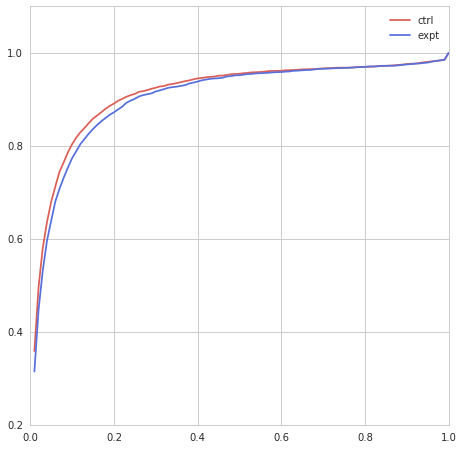

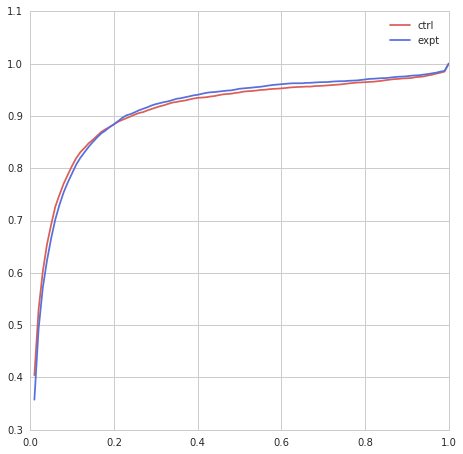

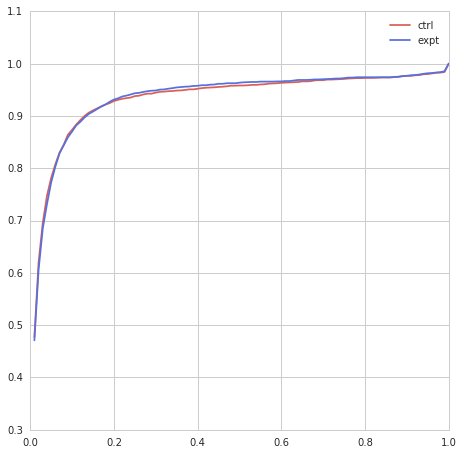

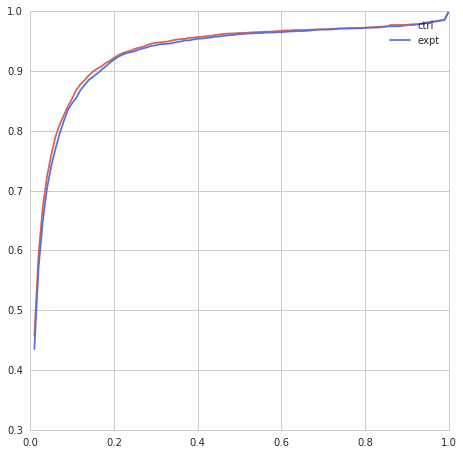

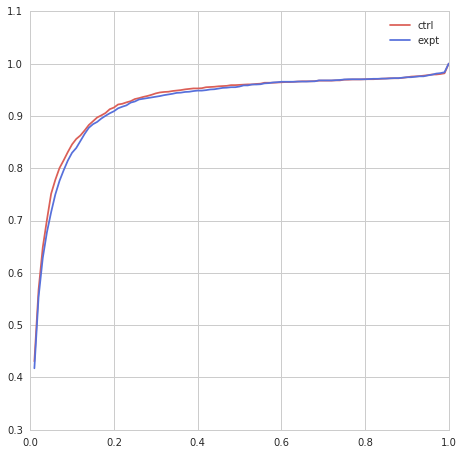

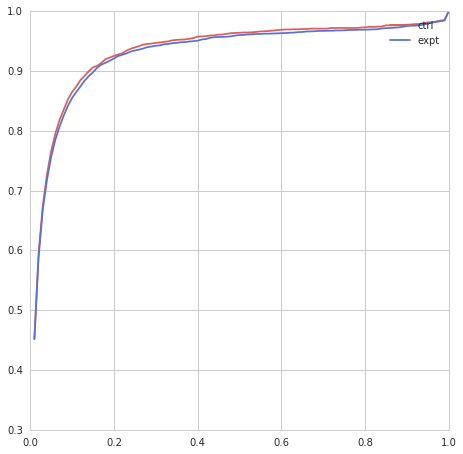

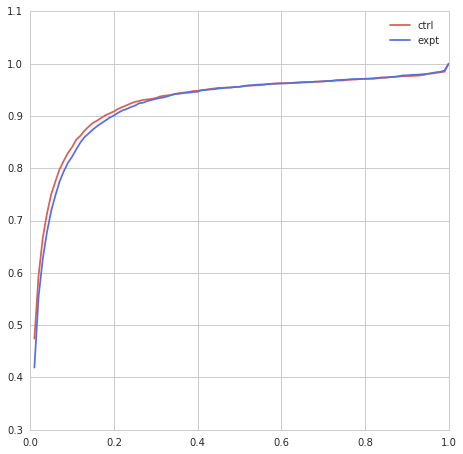

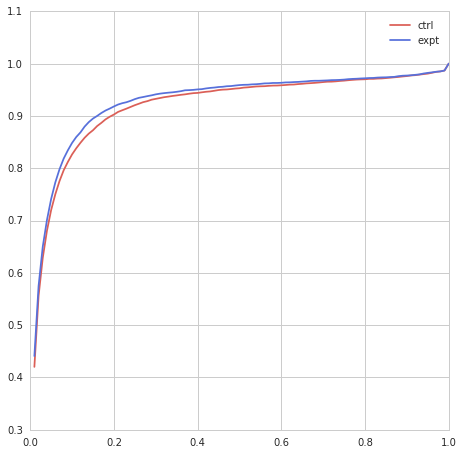

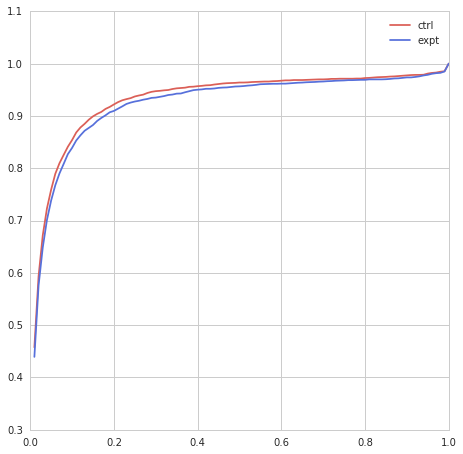

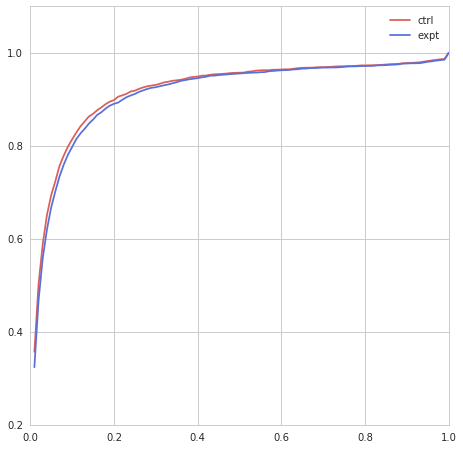

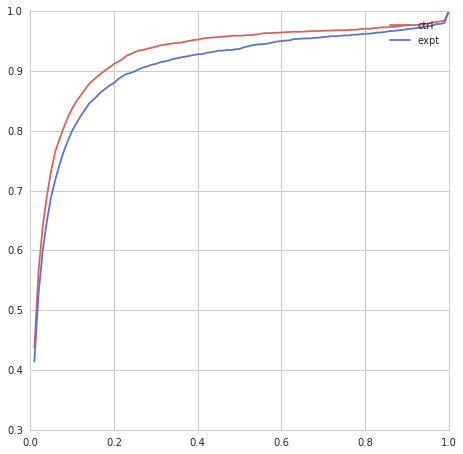

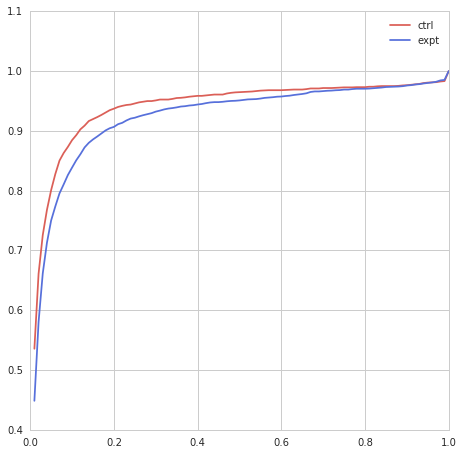

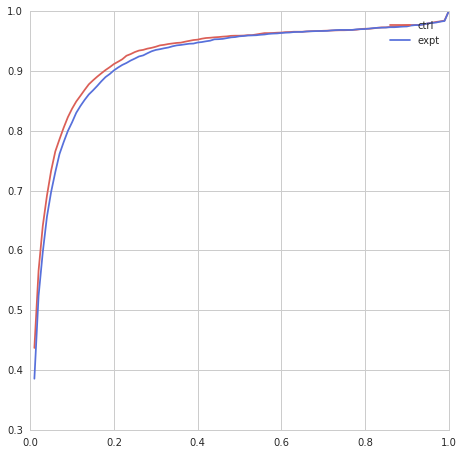

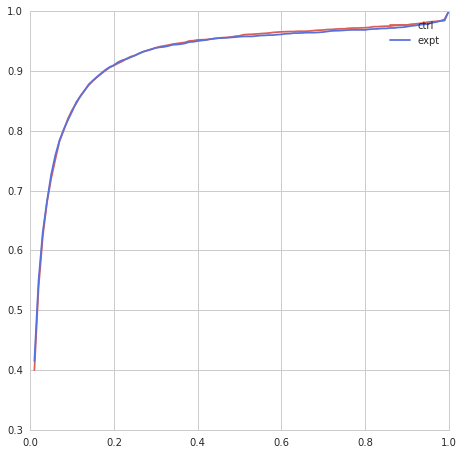

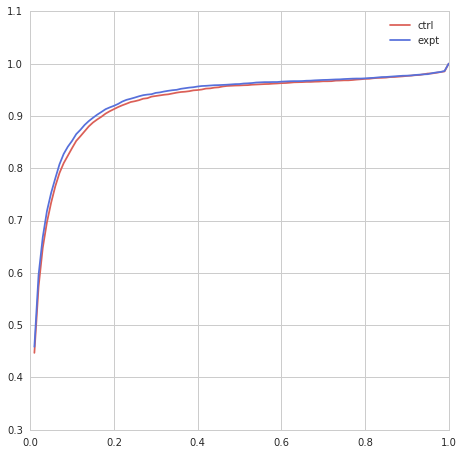

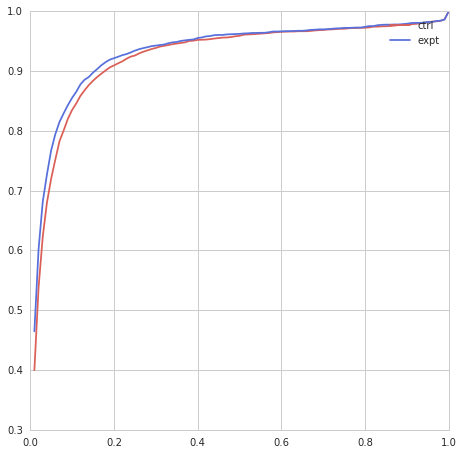

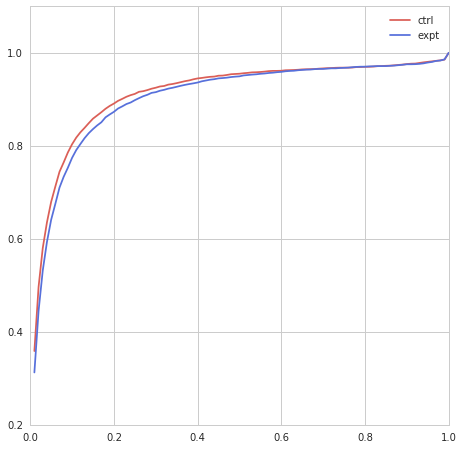

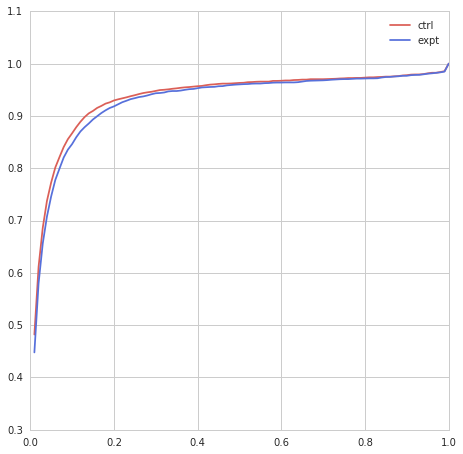

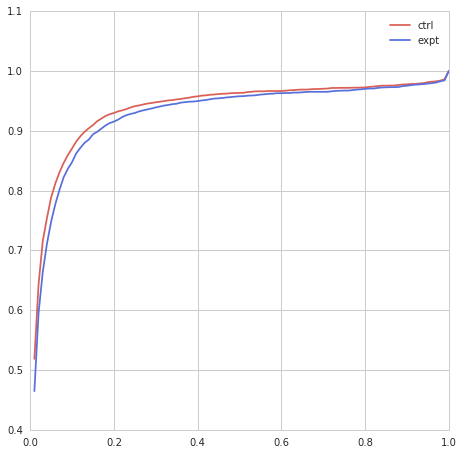

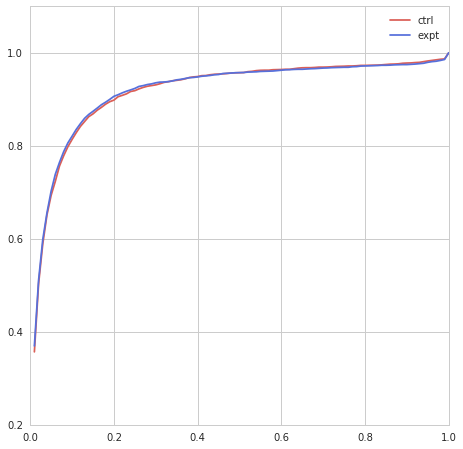

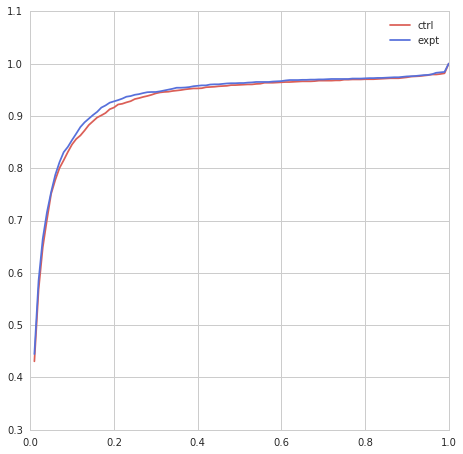

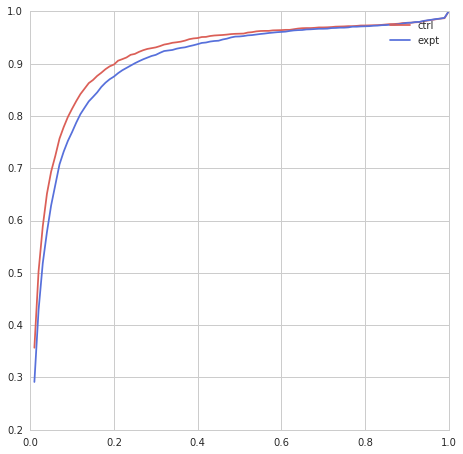

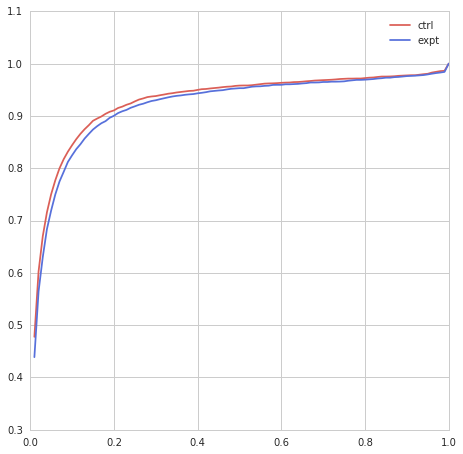

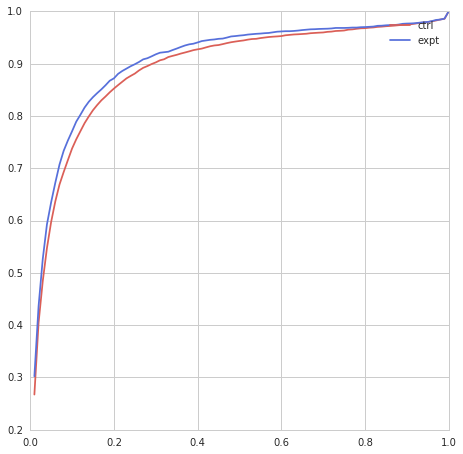

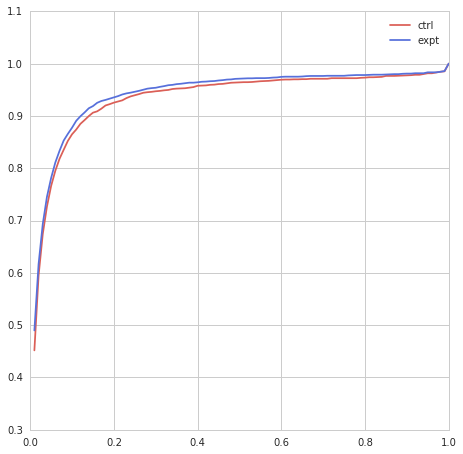

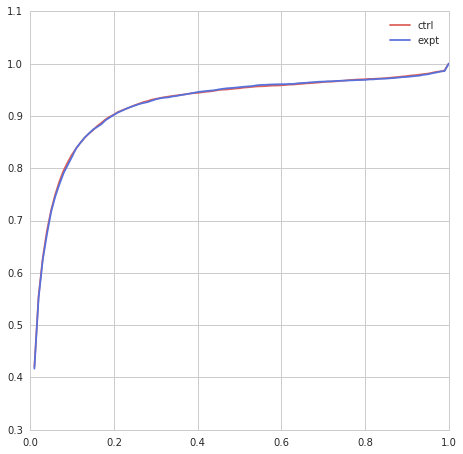

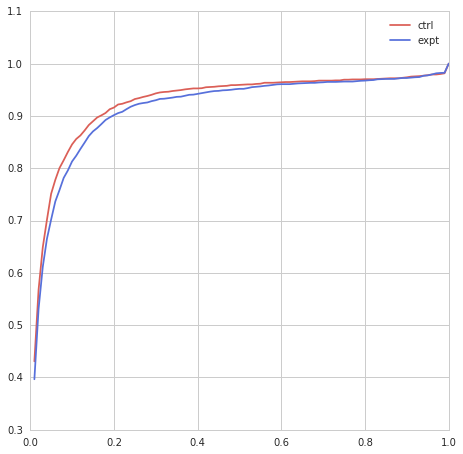

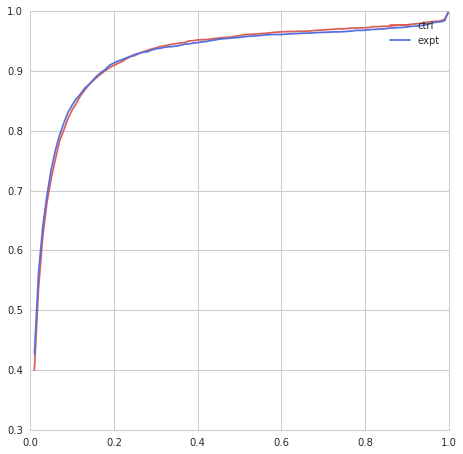

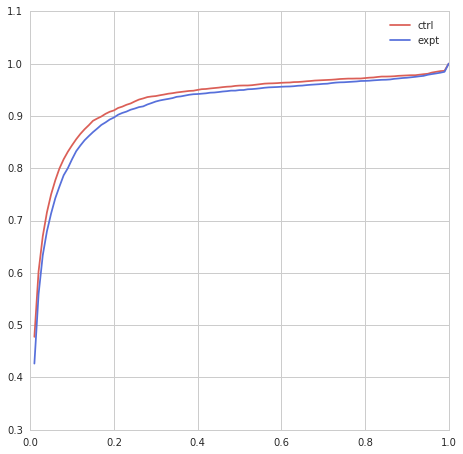

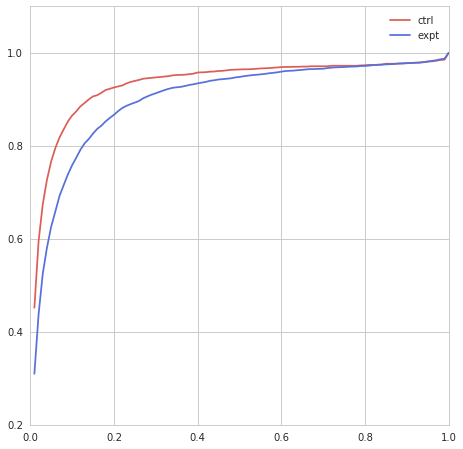

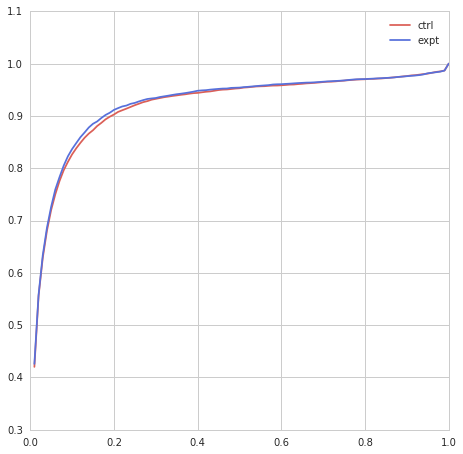

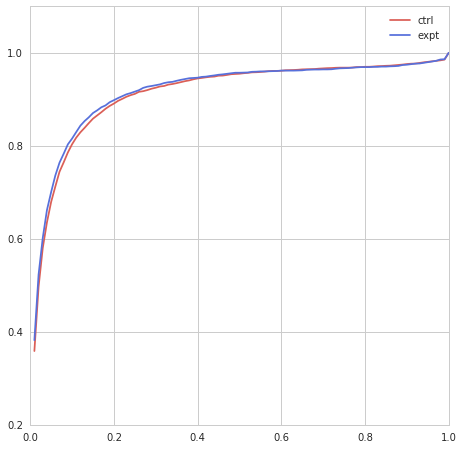

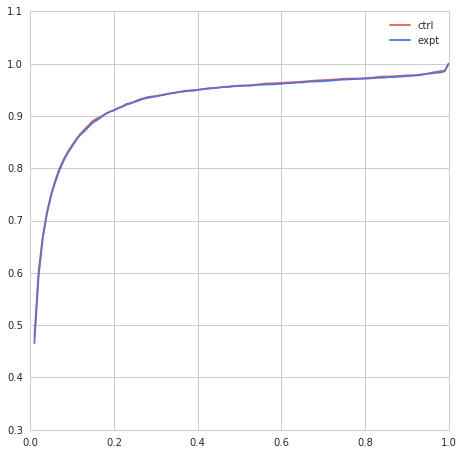

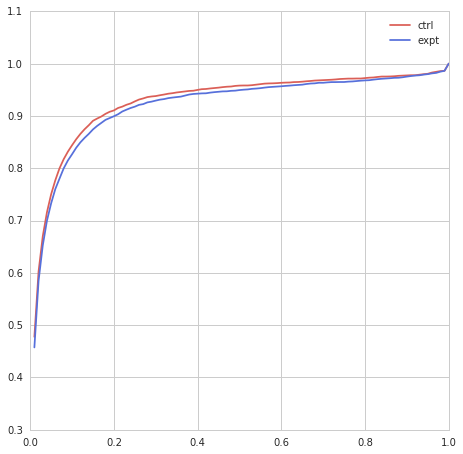

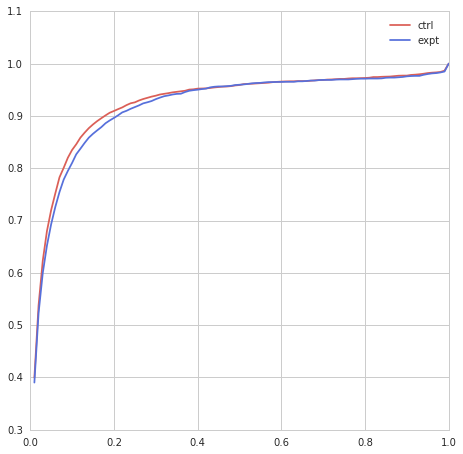

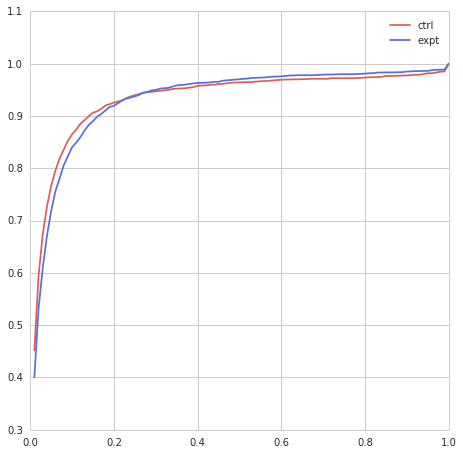

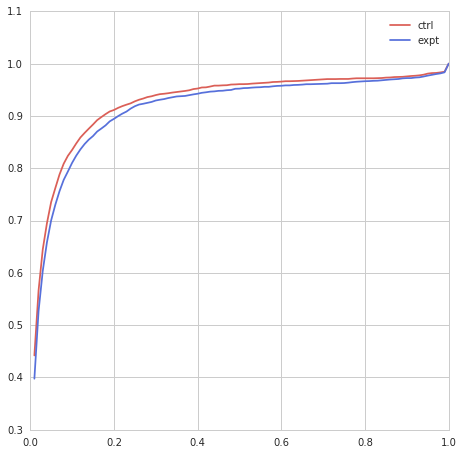

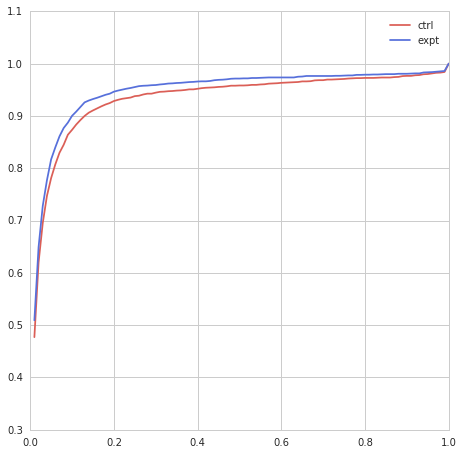

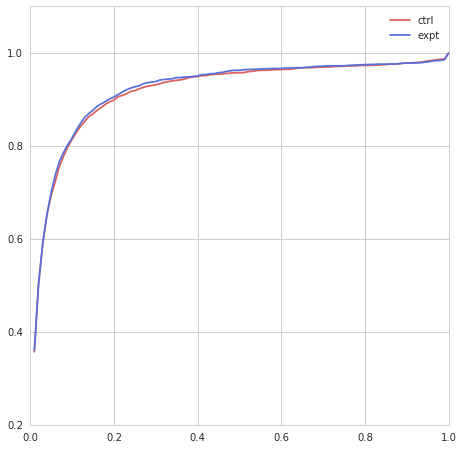

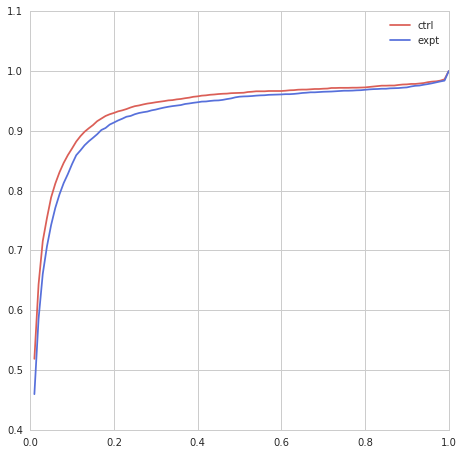

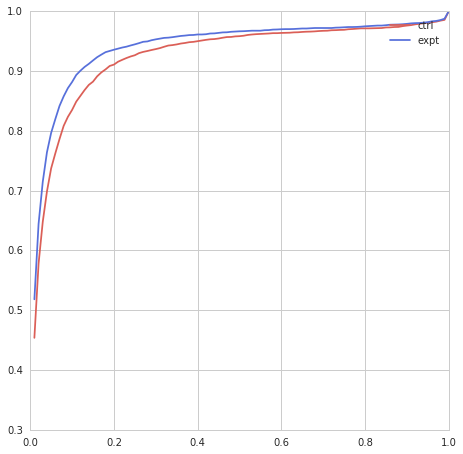

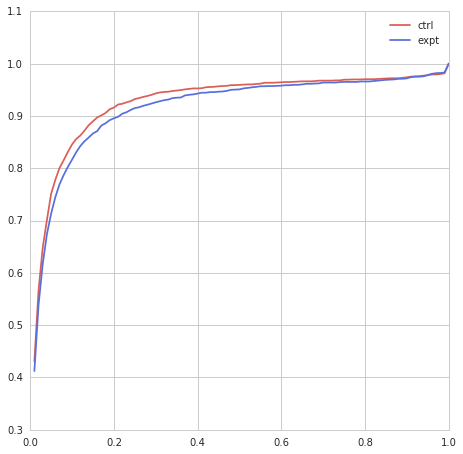

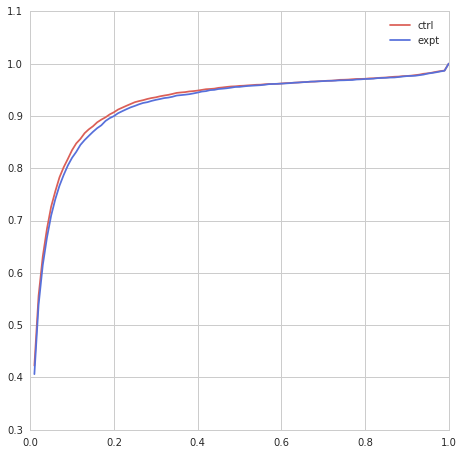

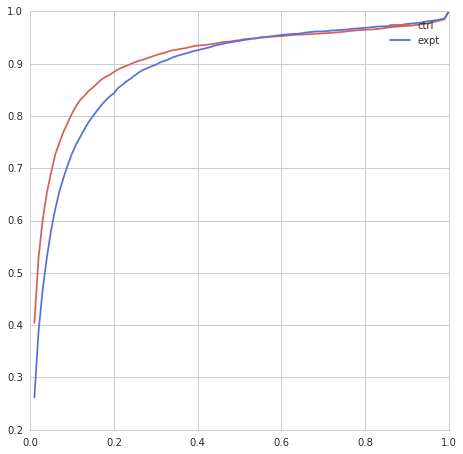

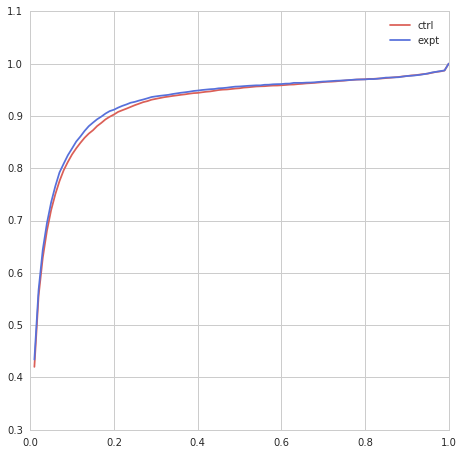

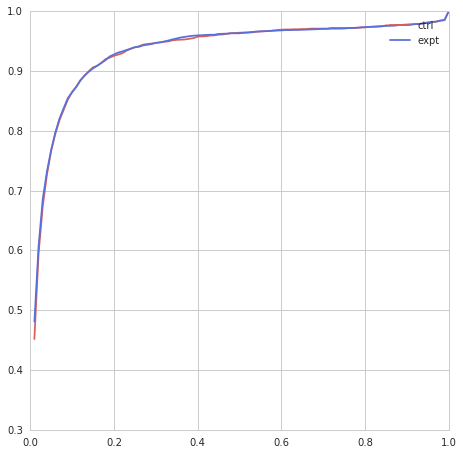

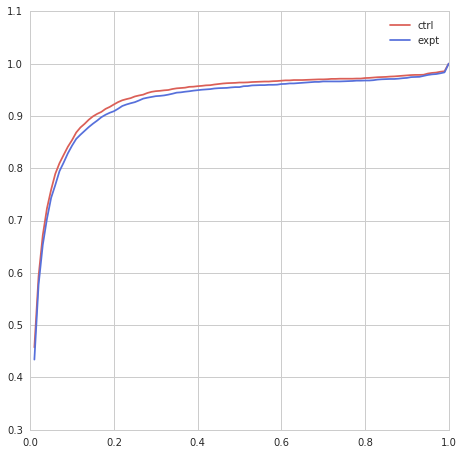

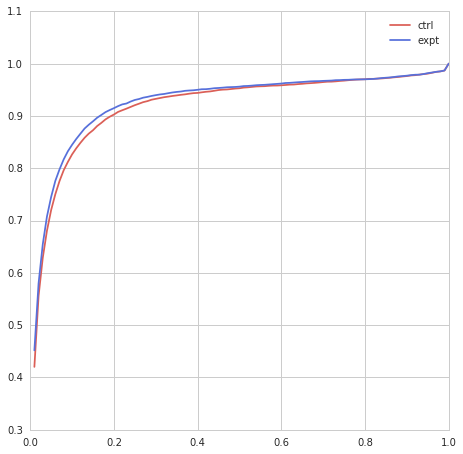

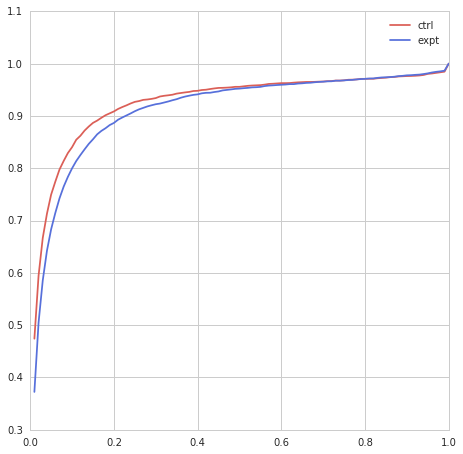

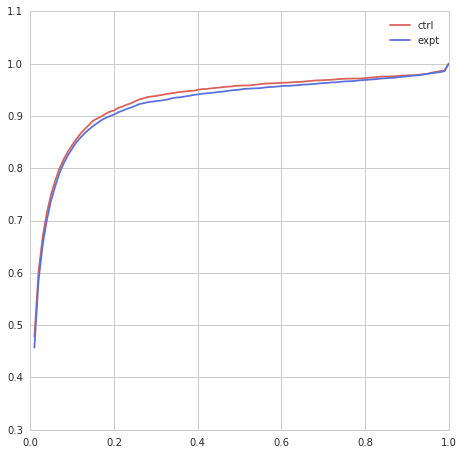

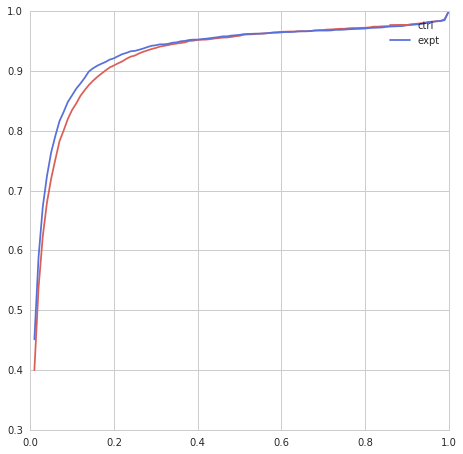

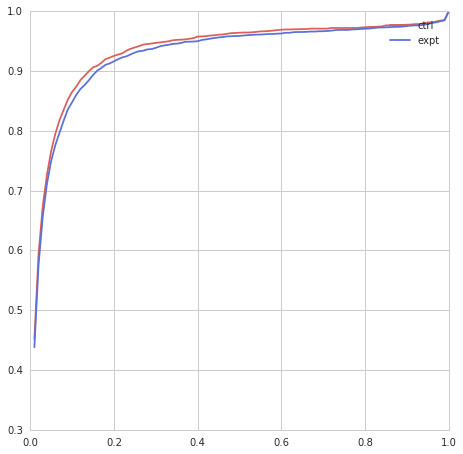

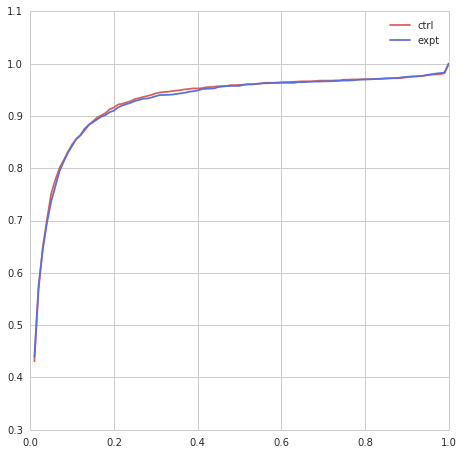

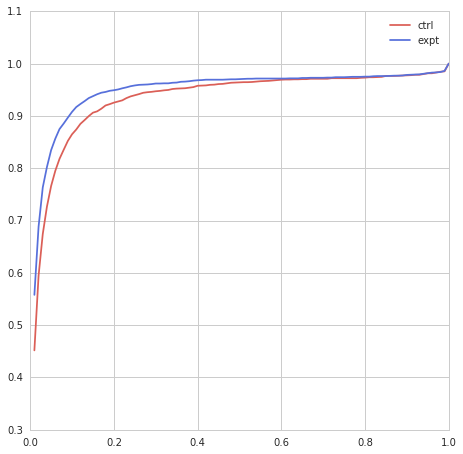

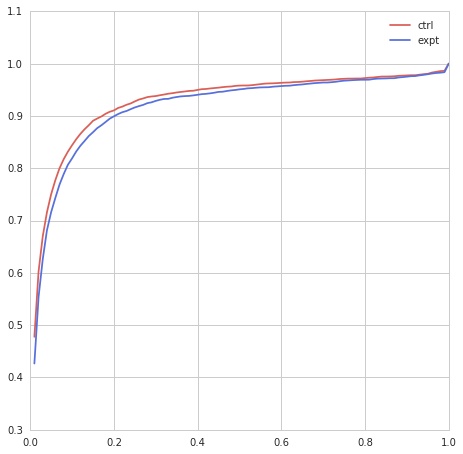

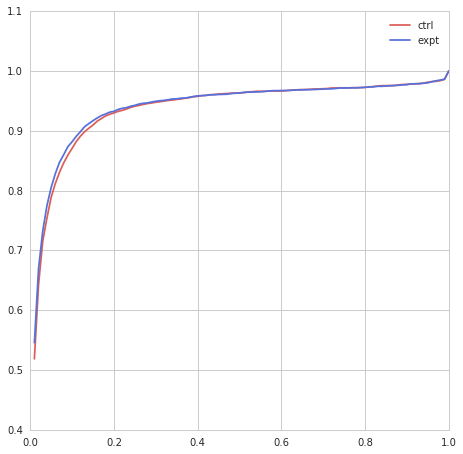

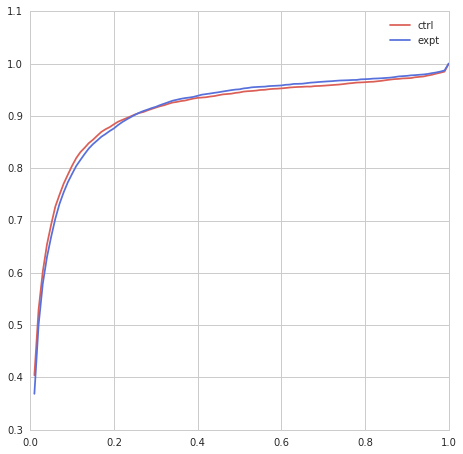

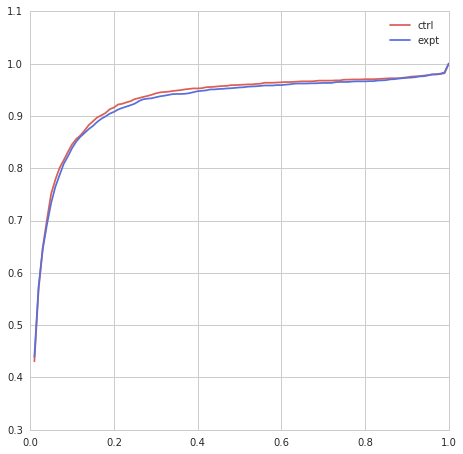

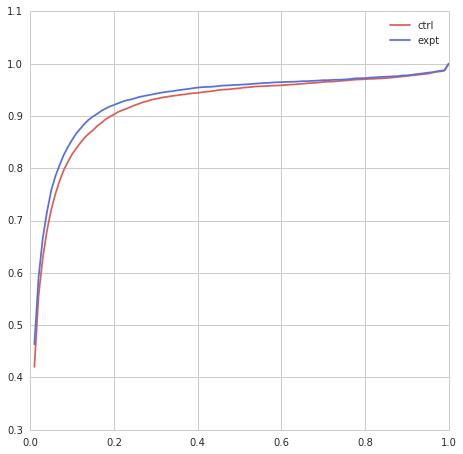

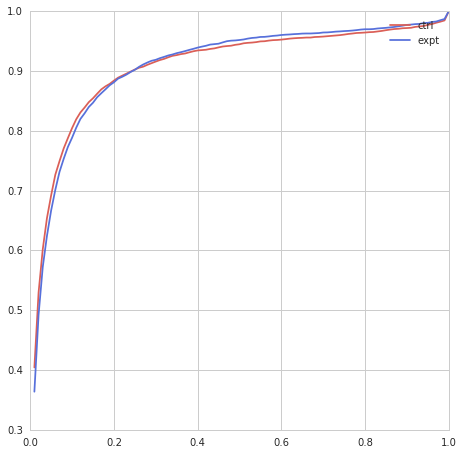

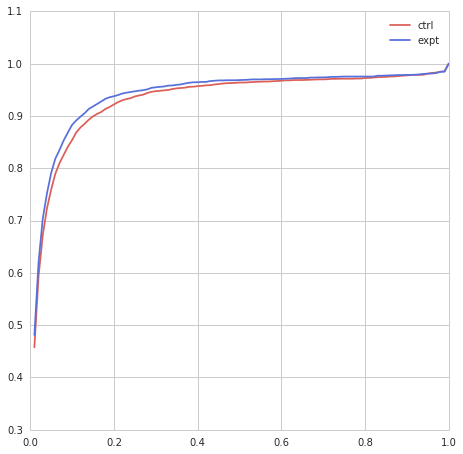

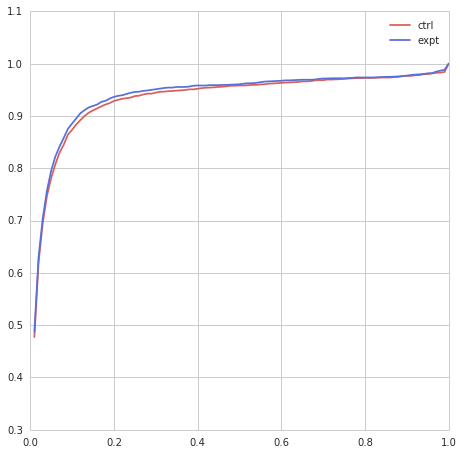

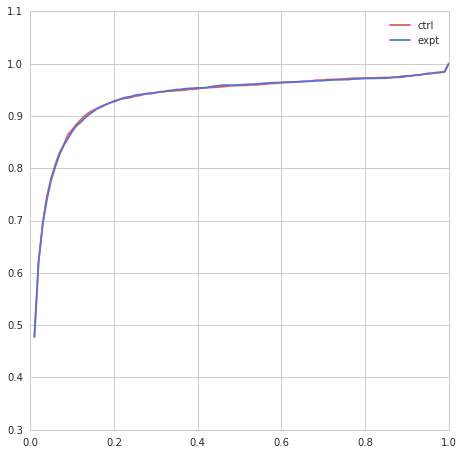

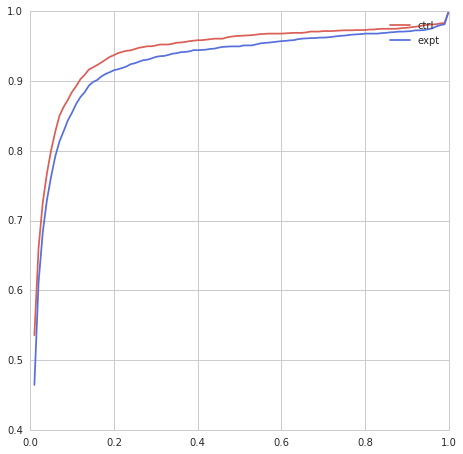

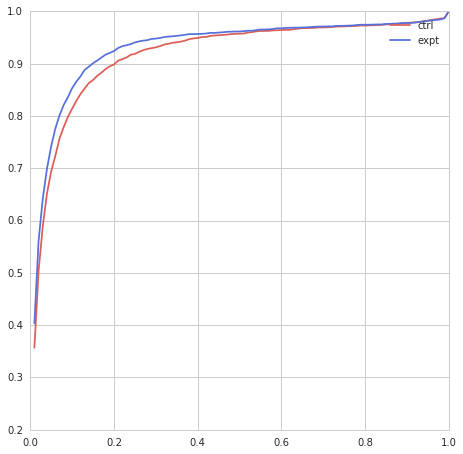

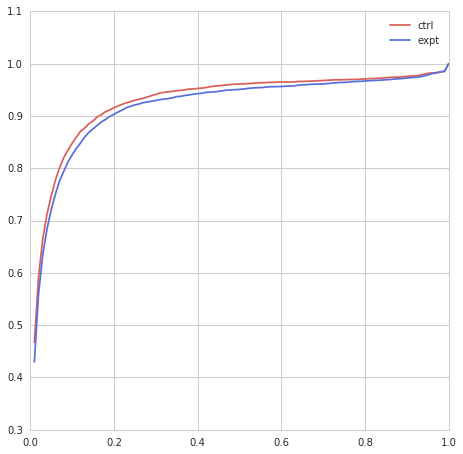

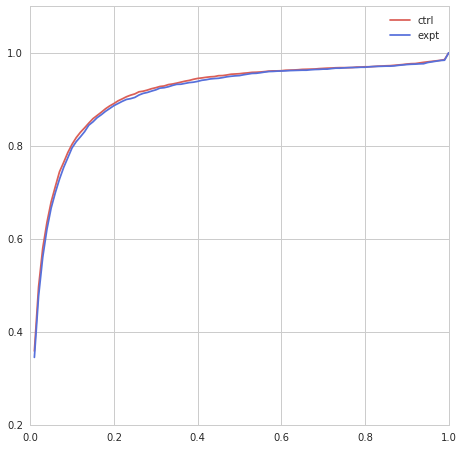

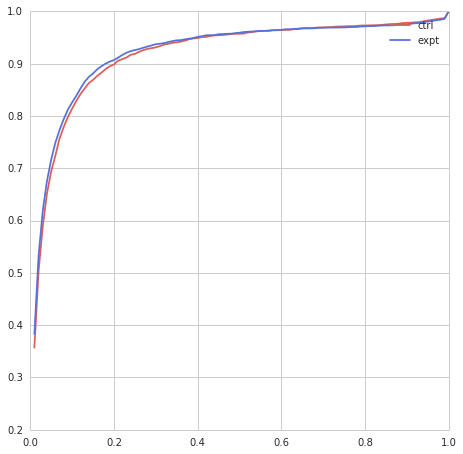

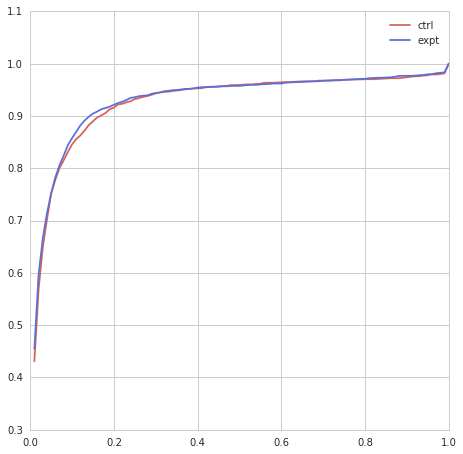

228/|/100%|| 228/228 [00:11<00:00, 441.86it/s]

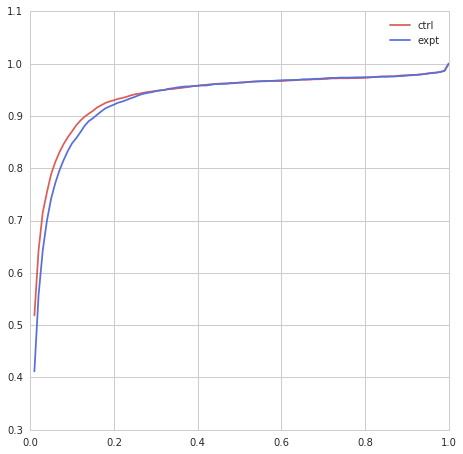

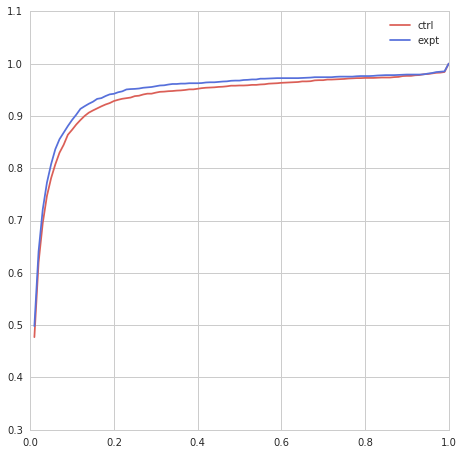

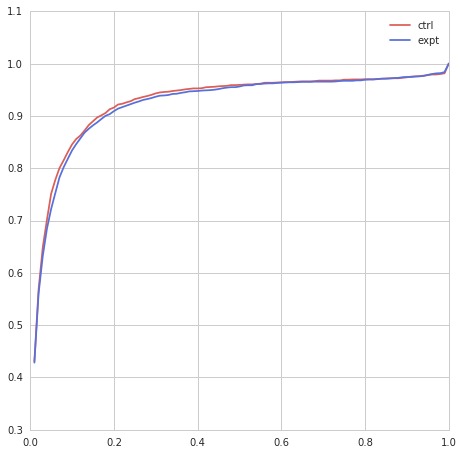

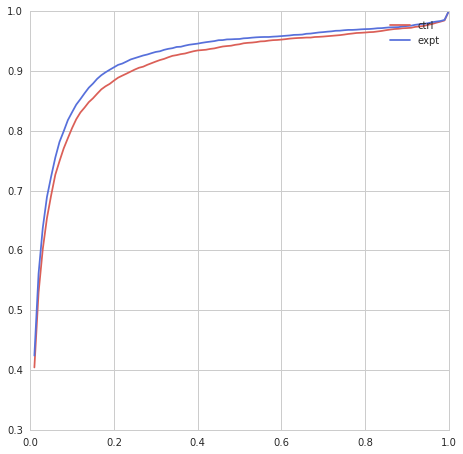

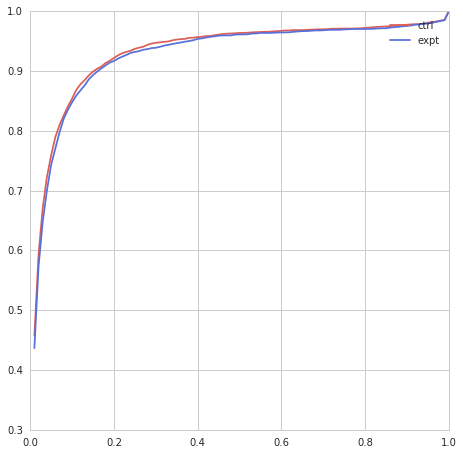

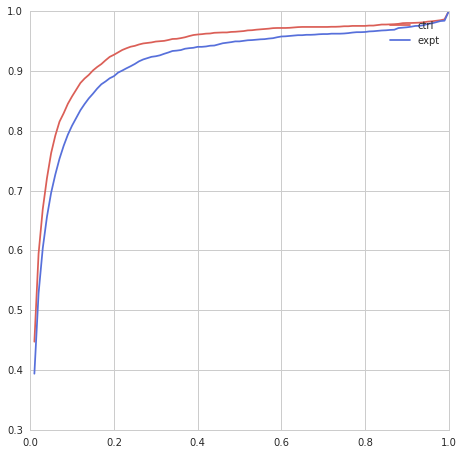

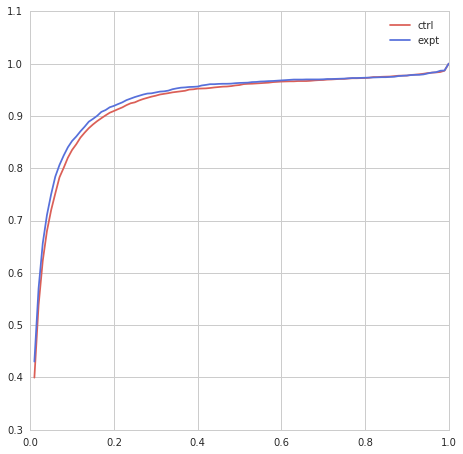

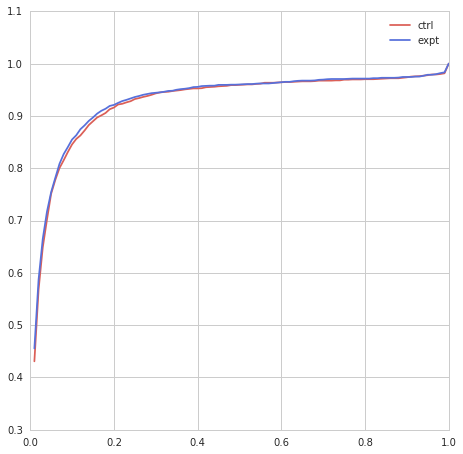

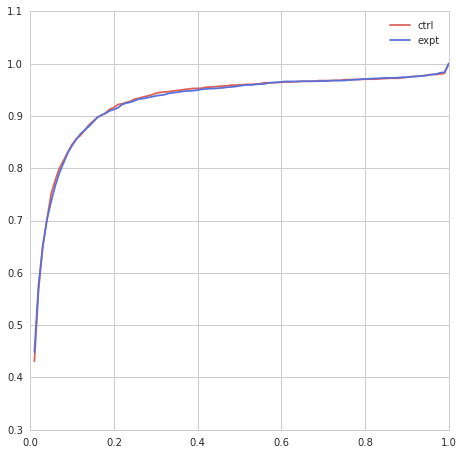

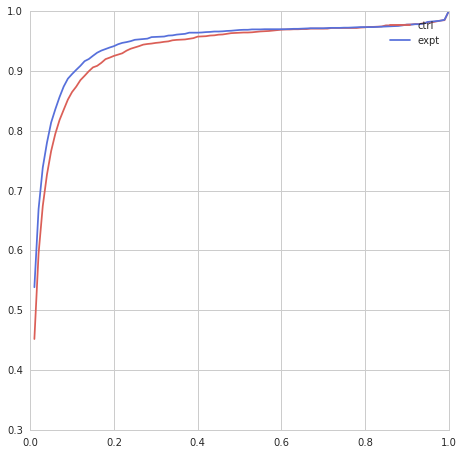

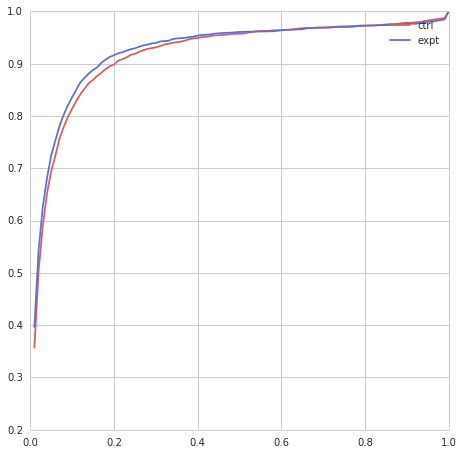

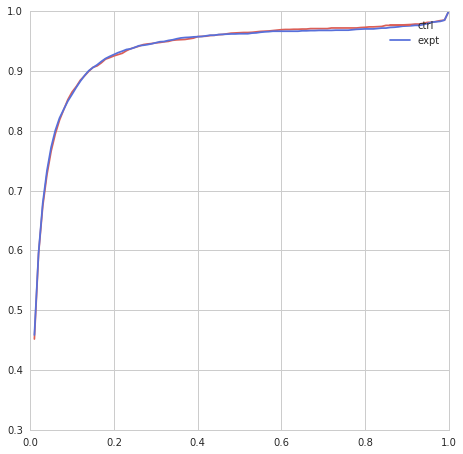

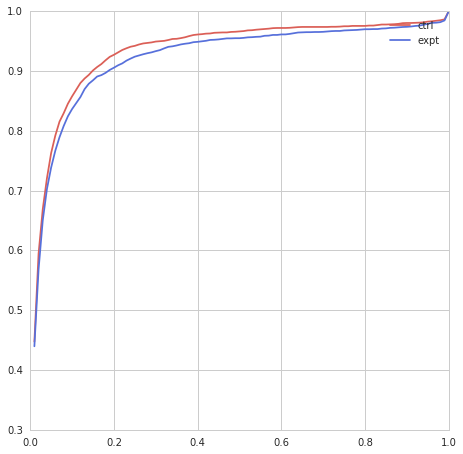

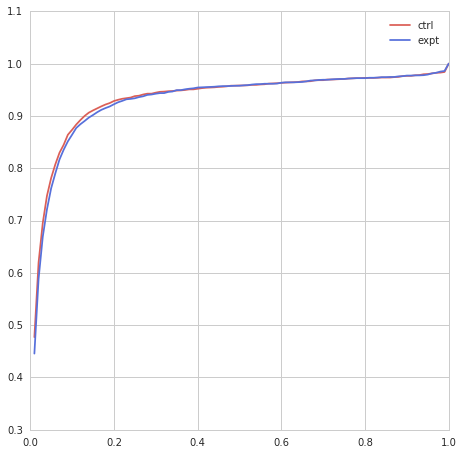

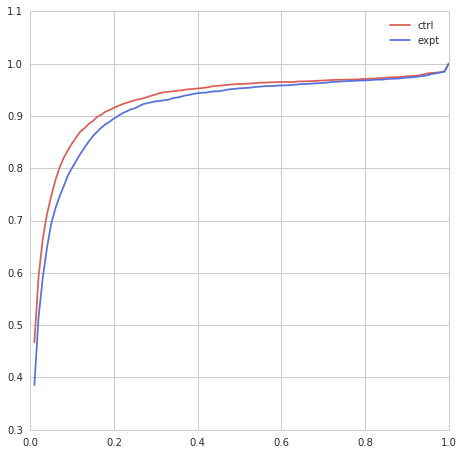

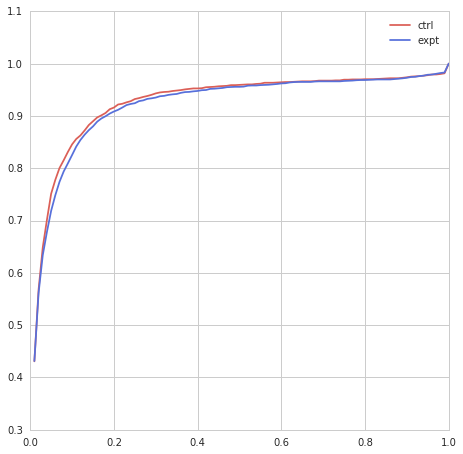

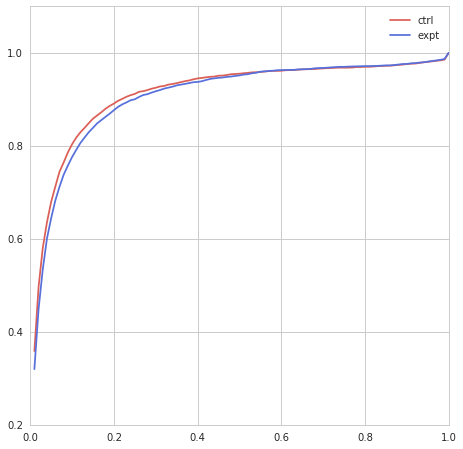

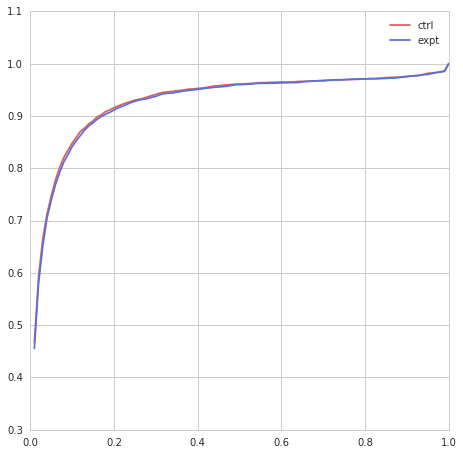

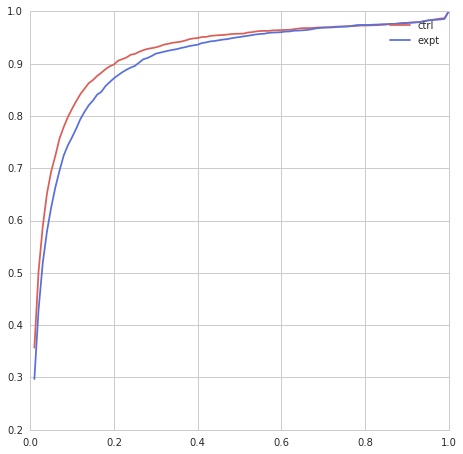

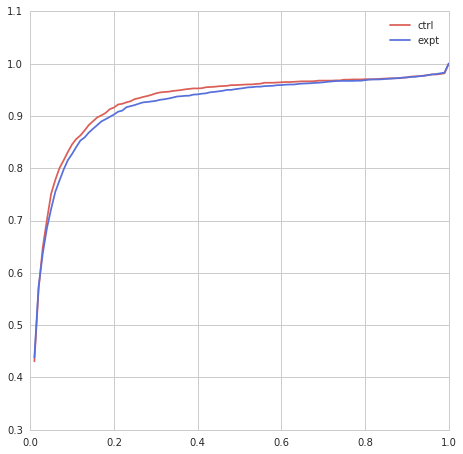

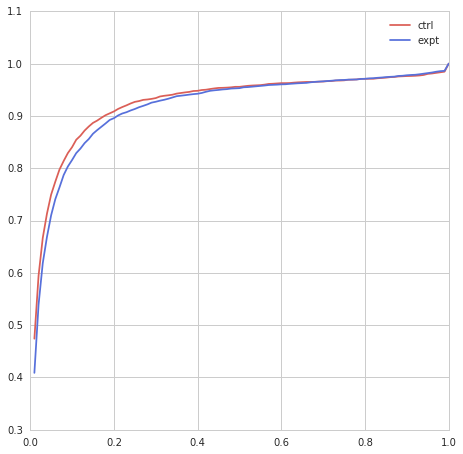

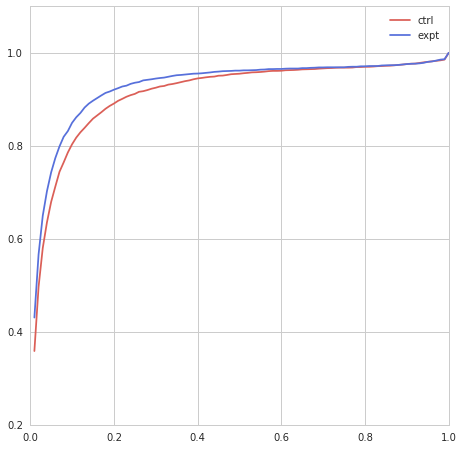

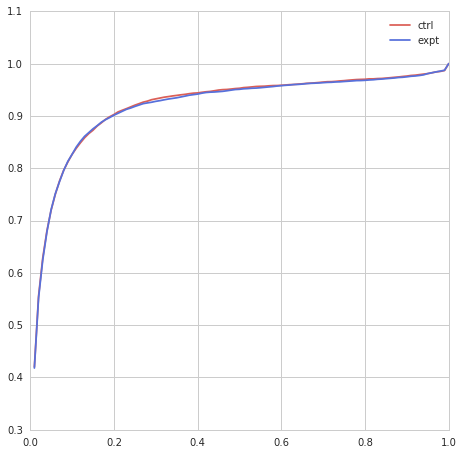

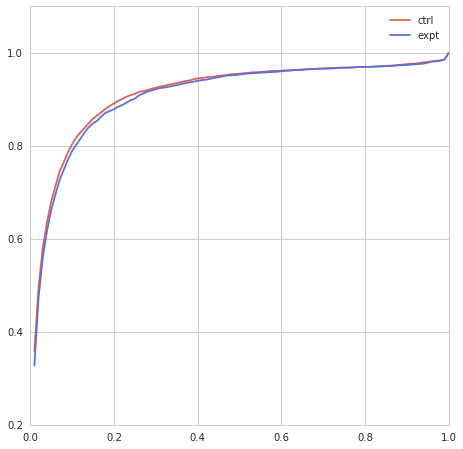

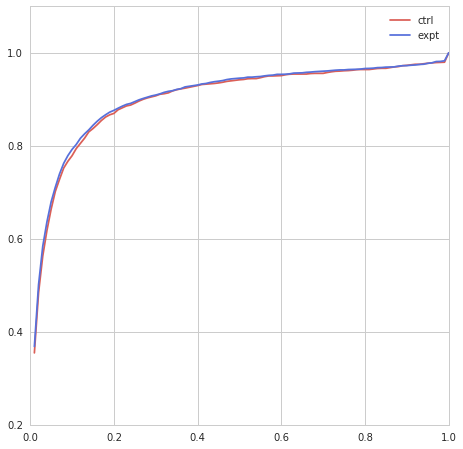

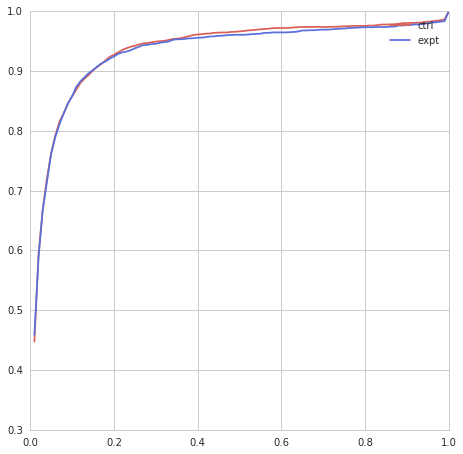

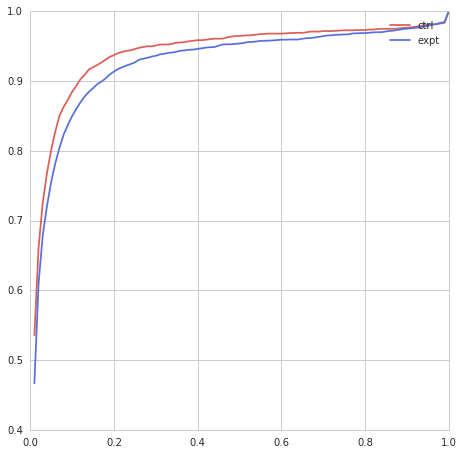

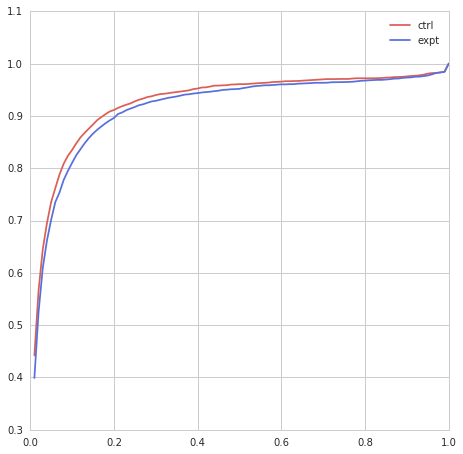

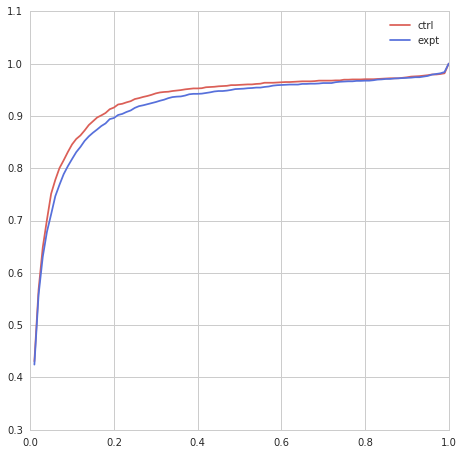

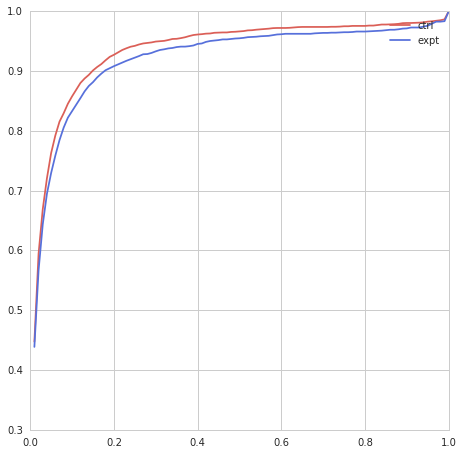

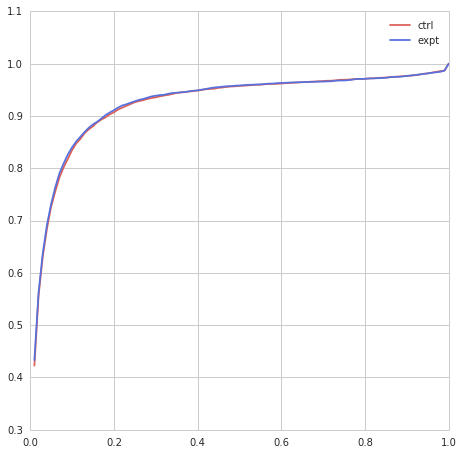

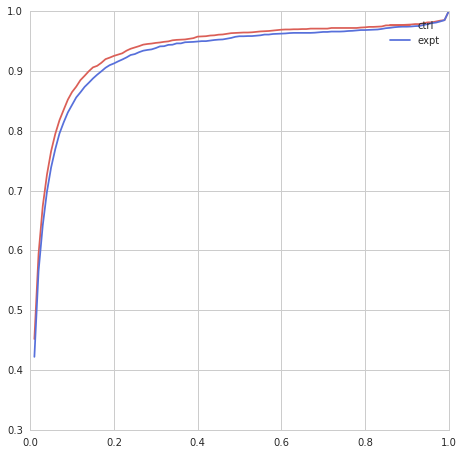

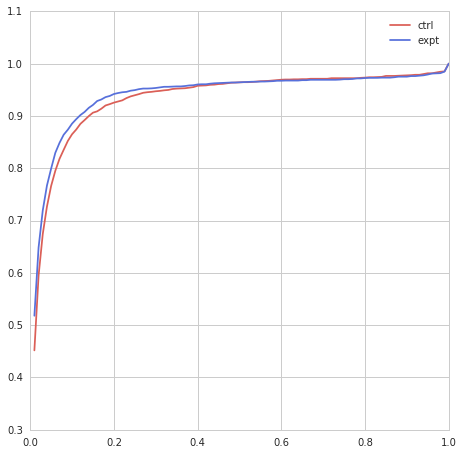

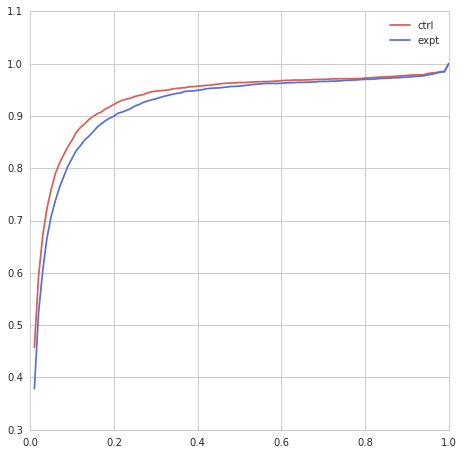

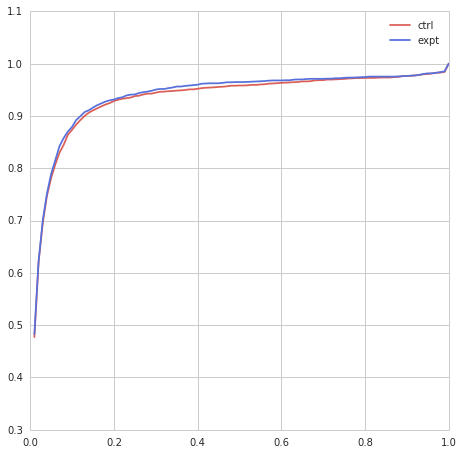

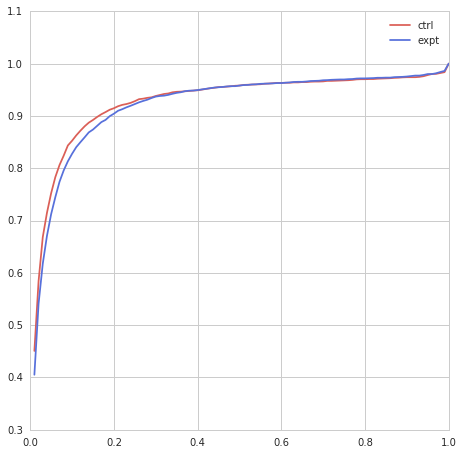

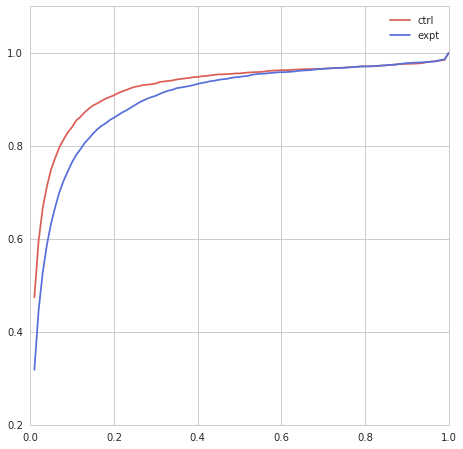

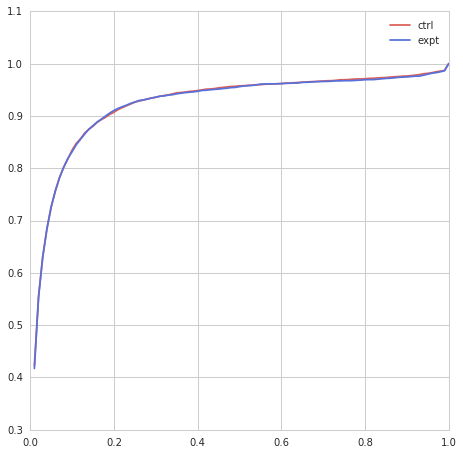

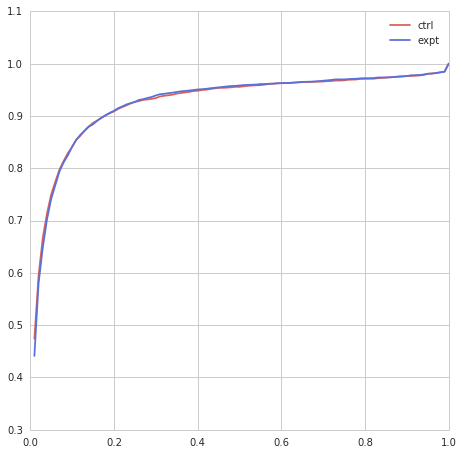

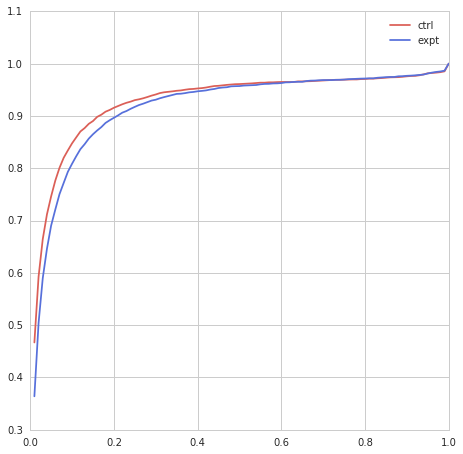

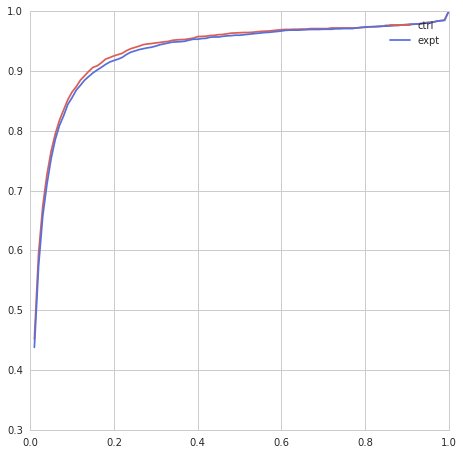

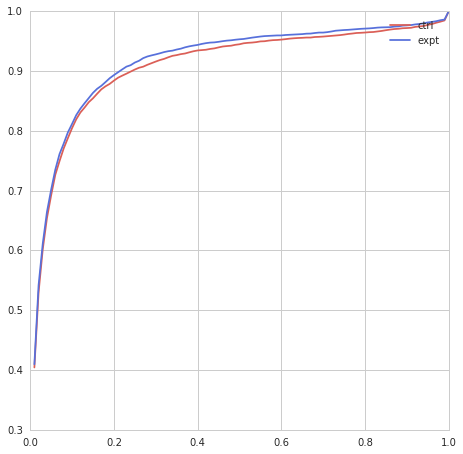

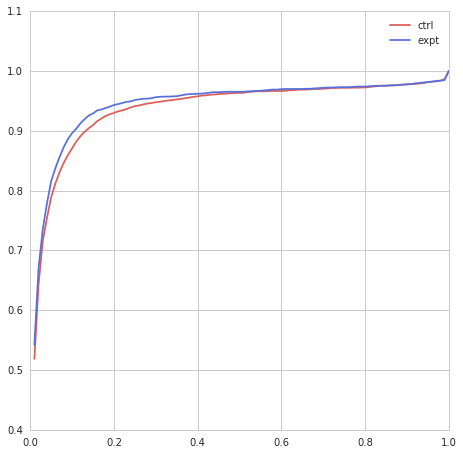

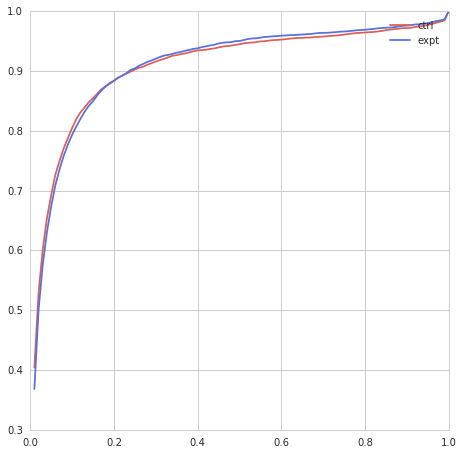

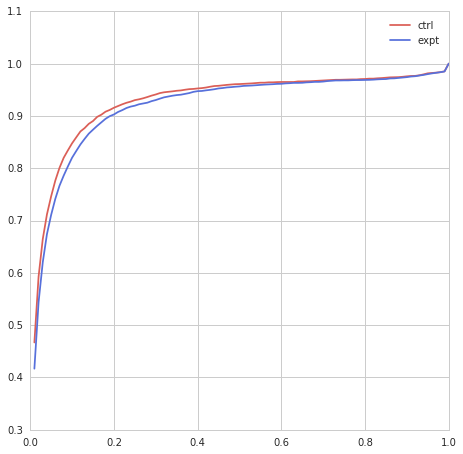

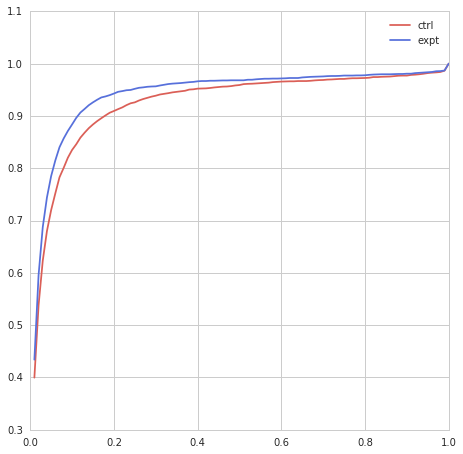

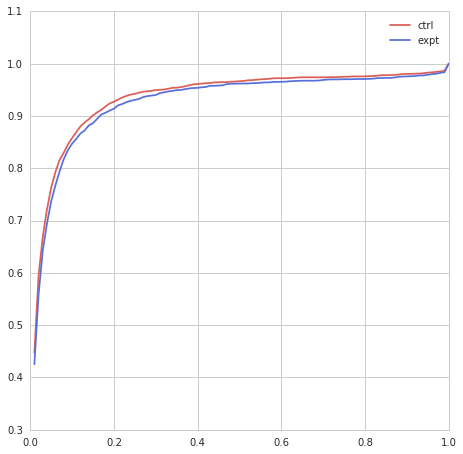

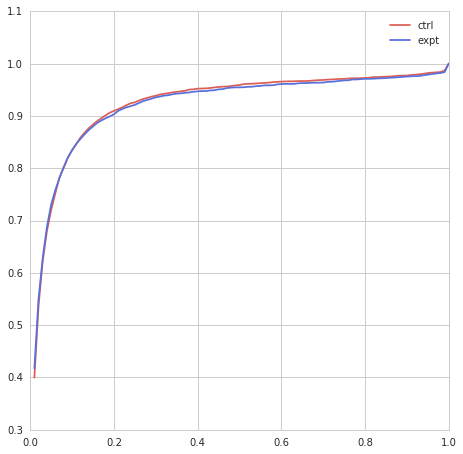

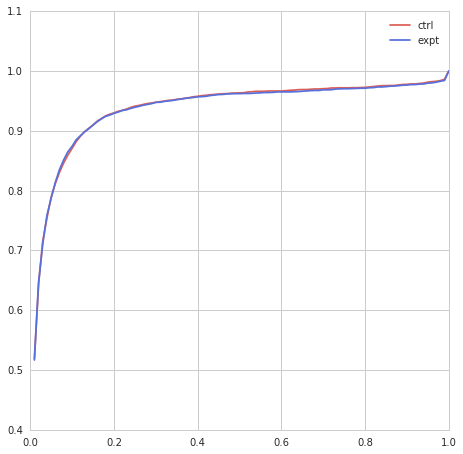

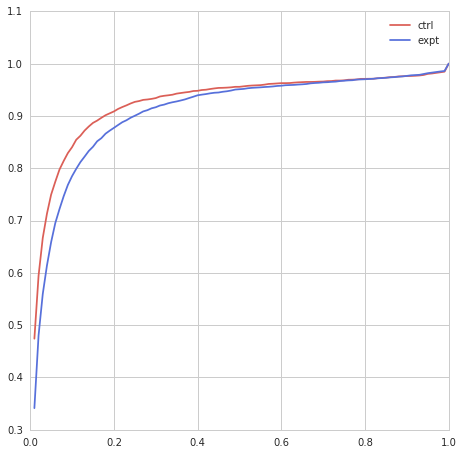

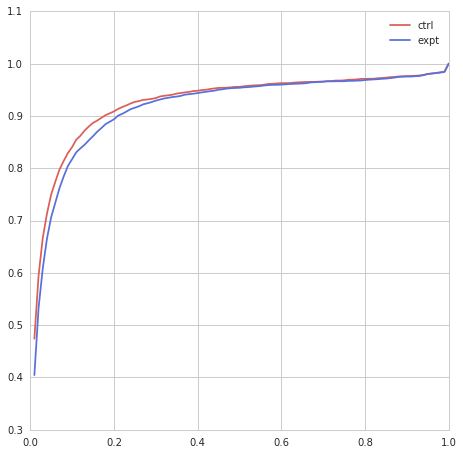

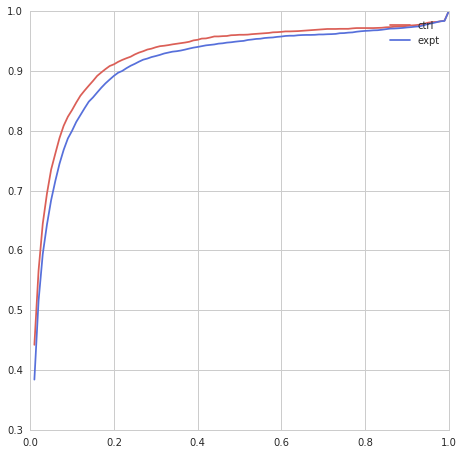

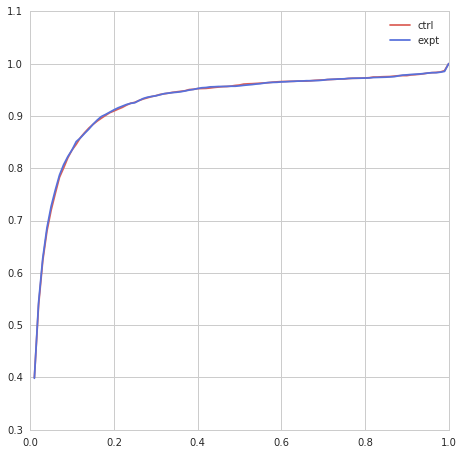

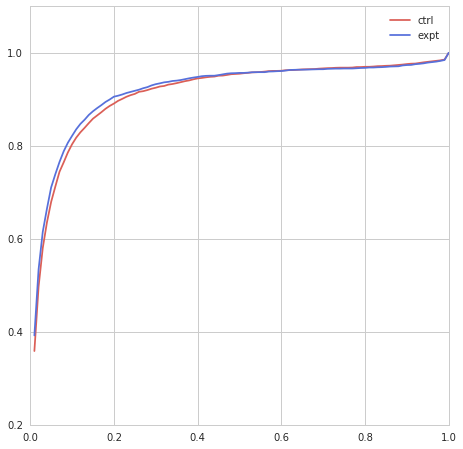

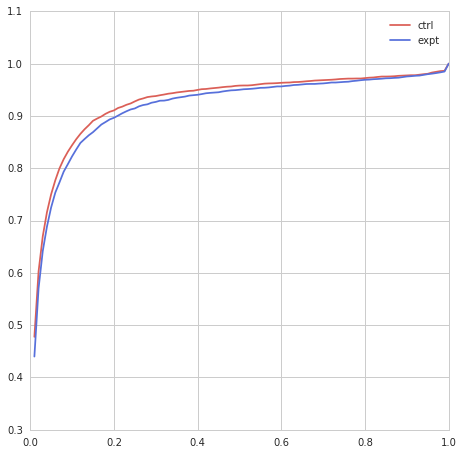

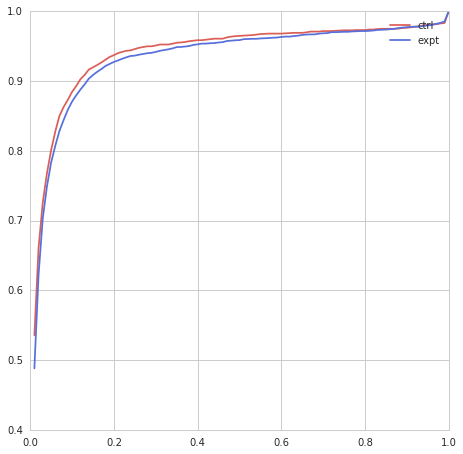

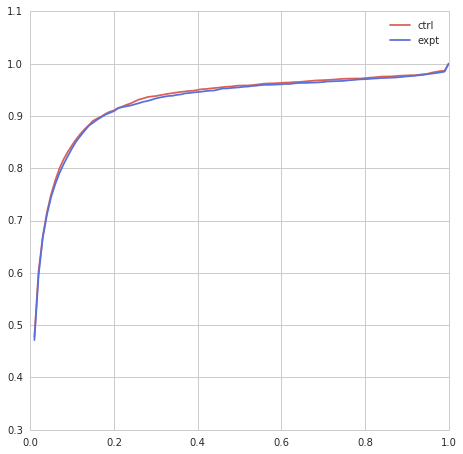

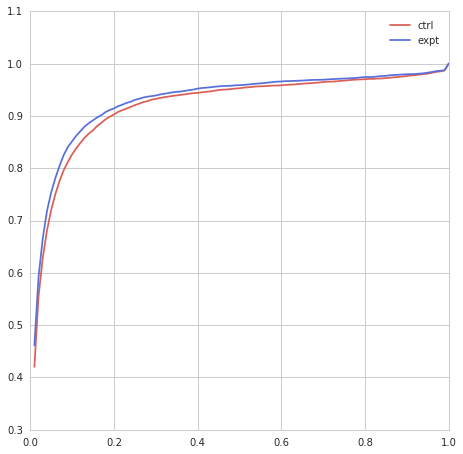

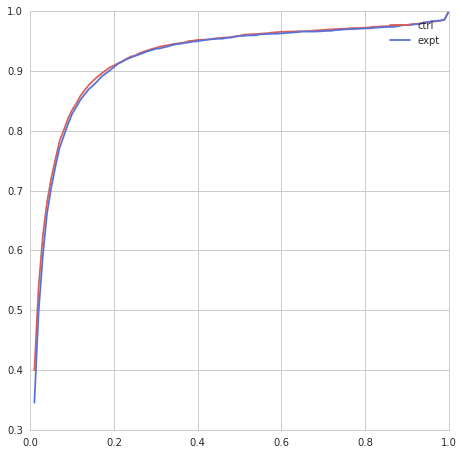

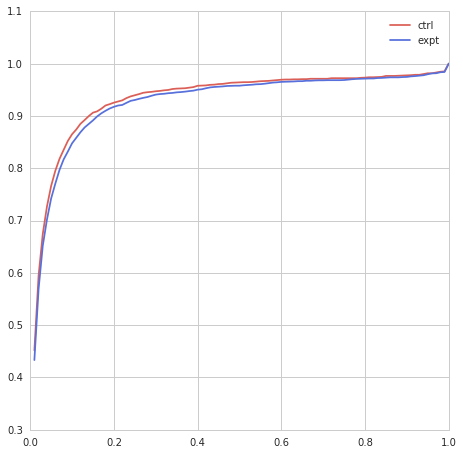

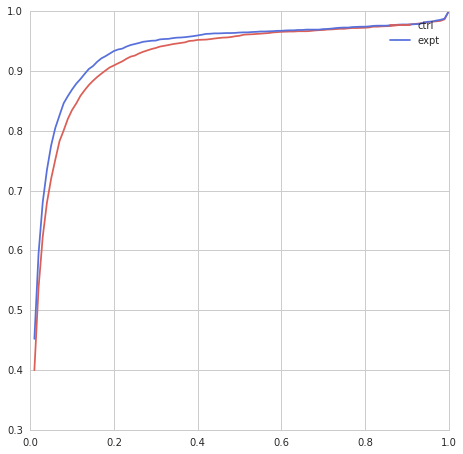

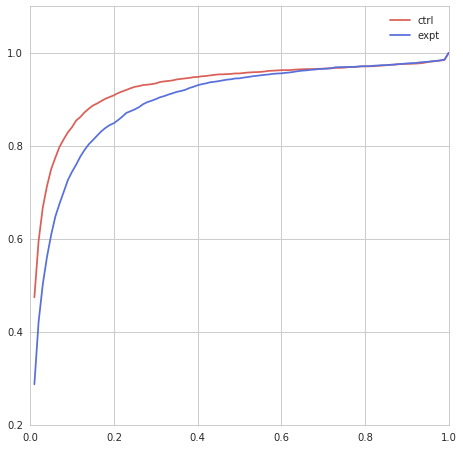

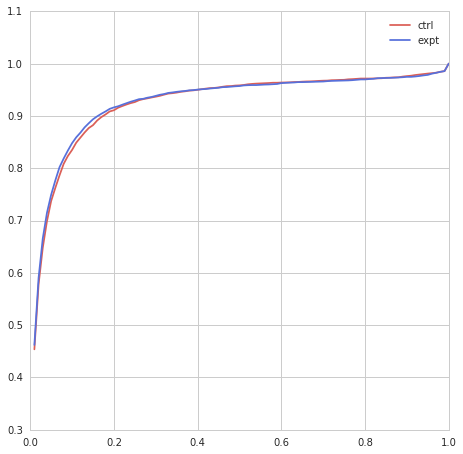

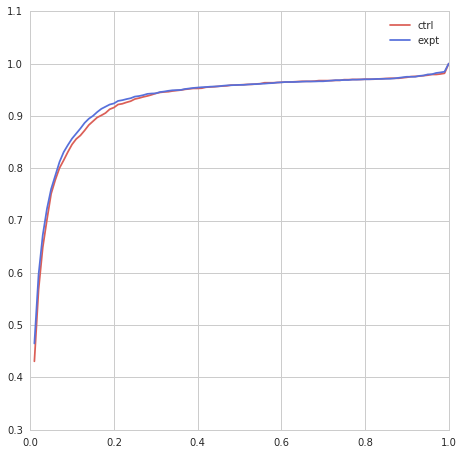

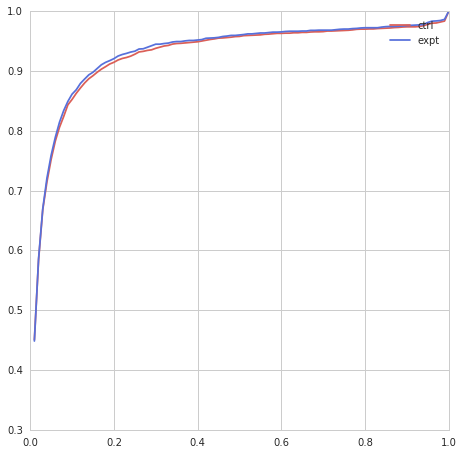

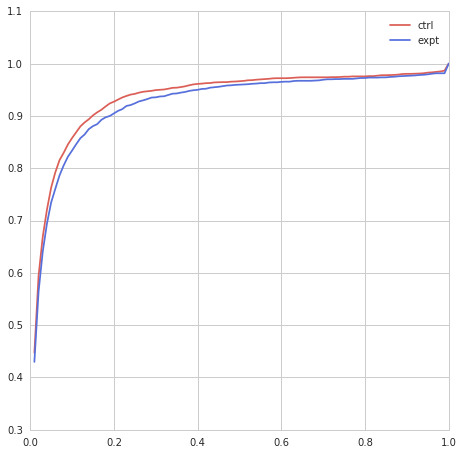

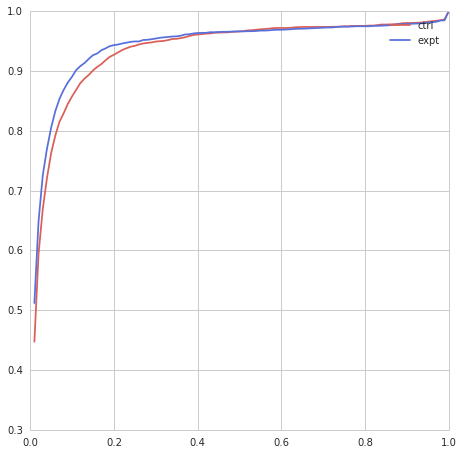

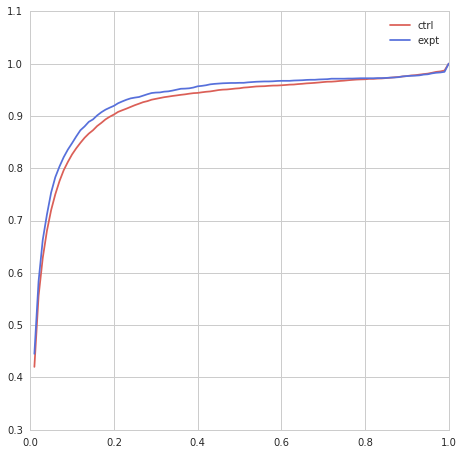

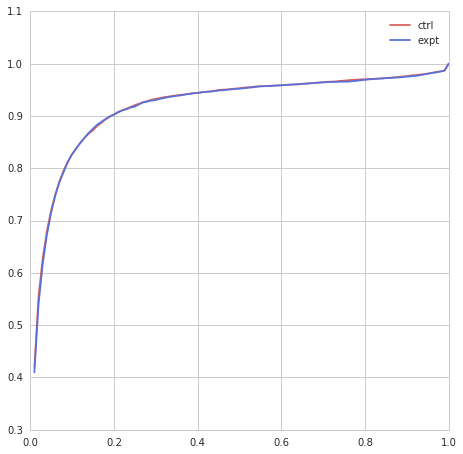

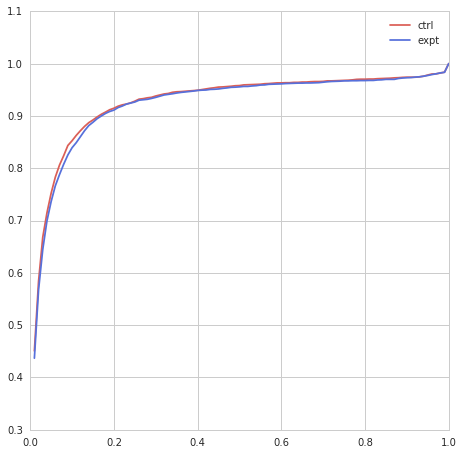

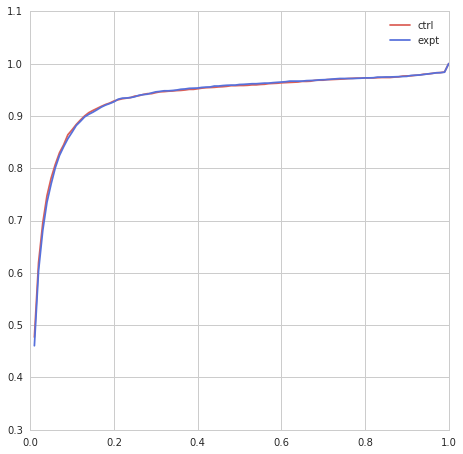

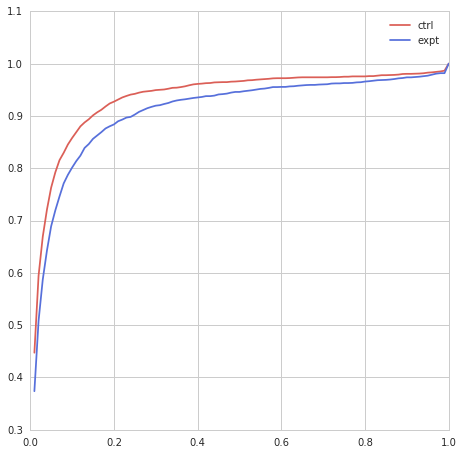

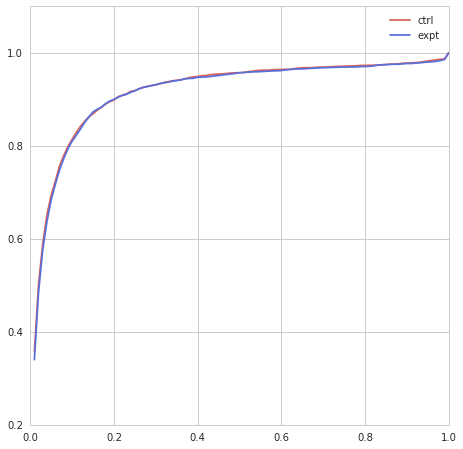

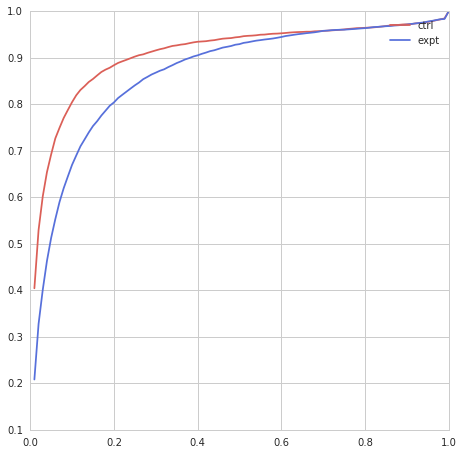

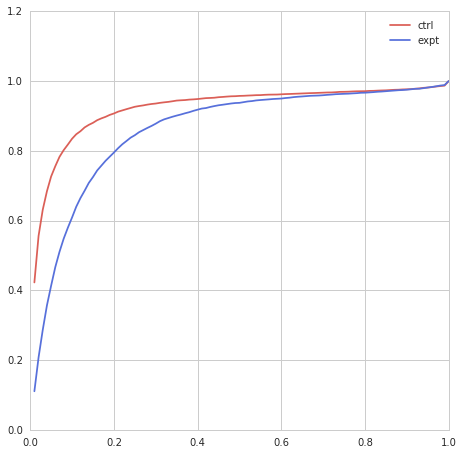

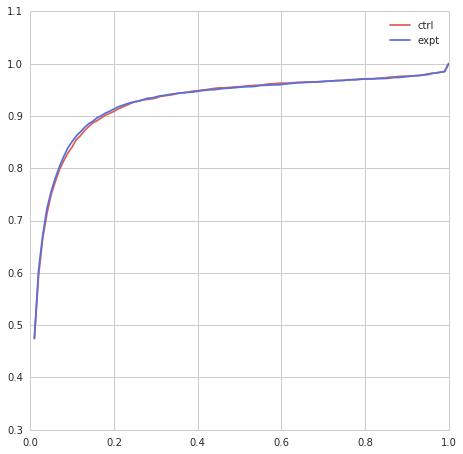

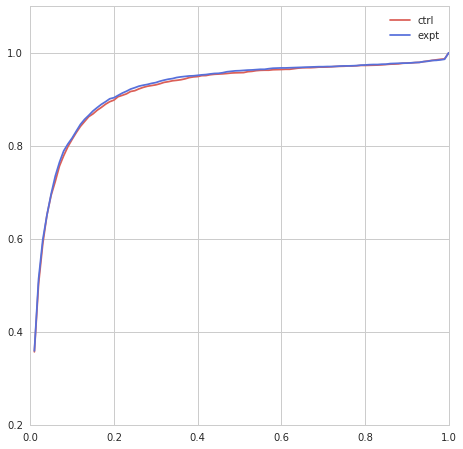

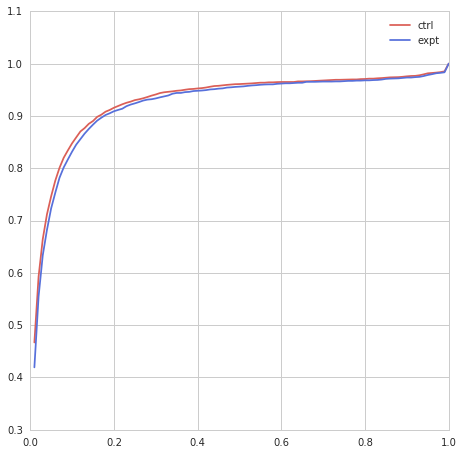

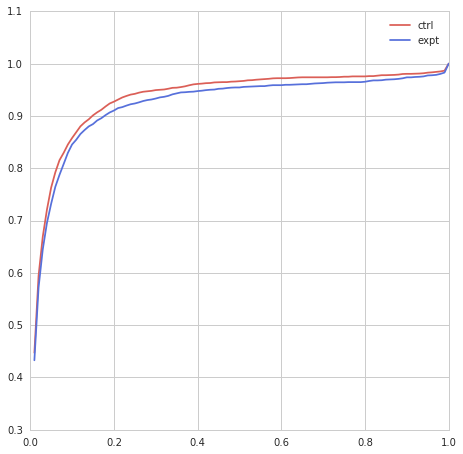

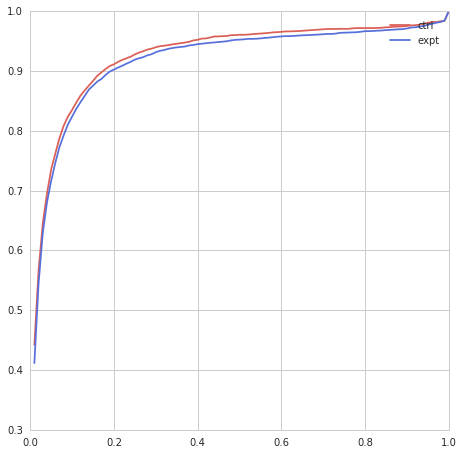

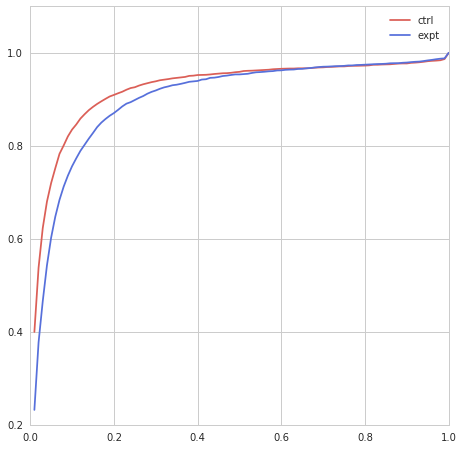

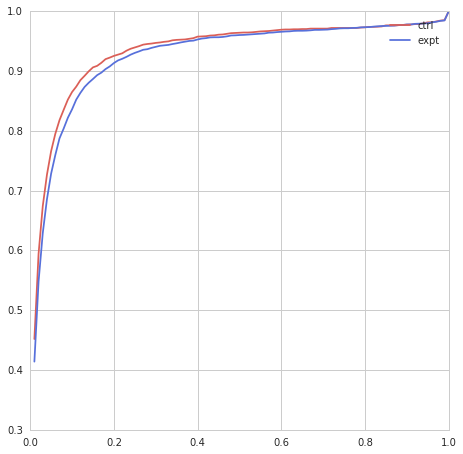

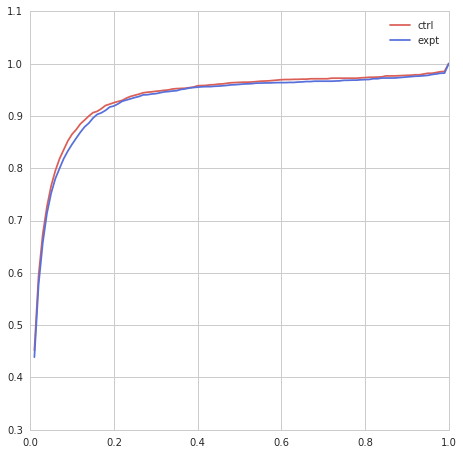

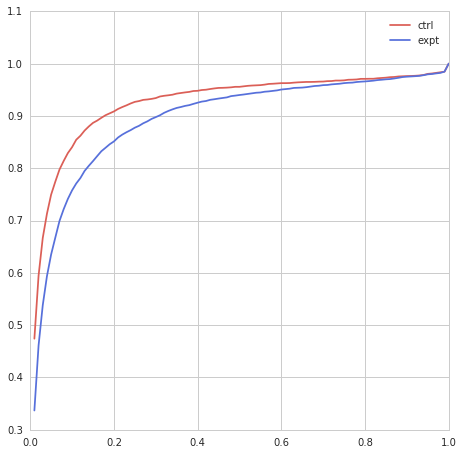

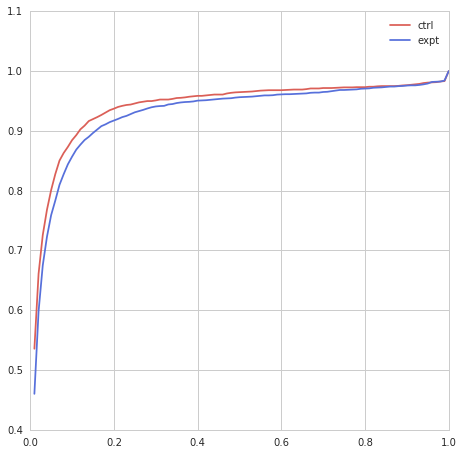

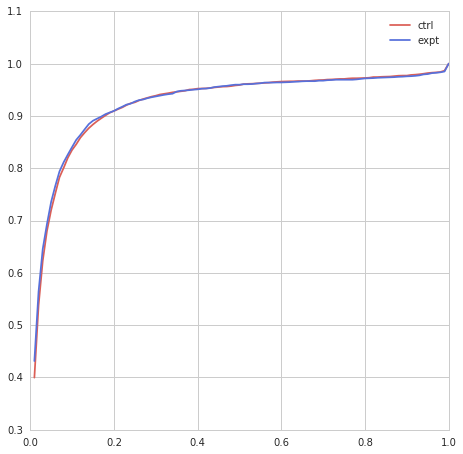

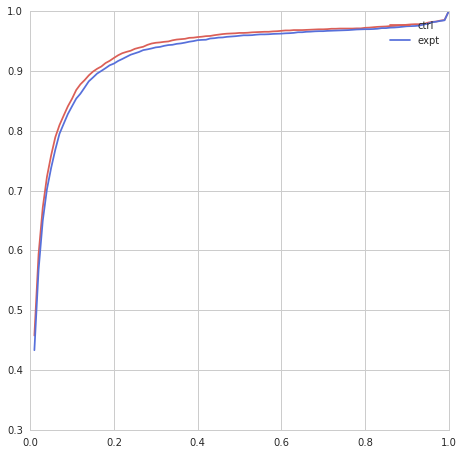

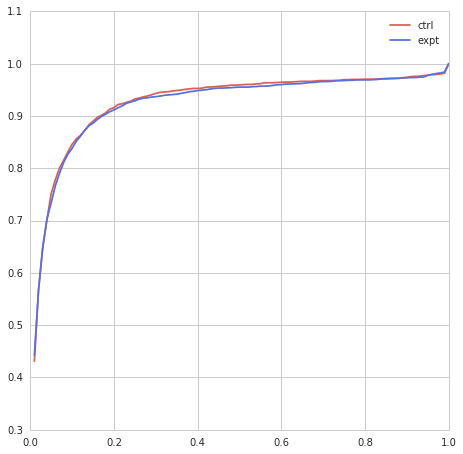

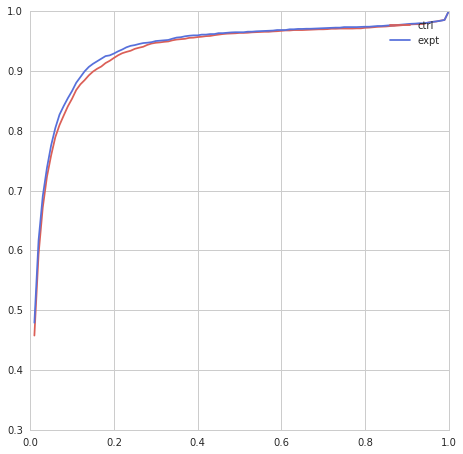

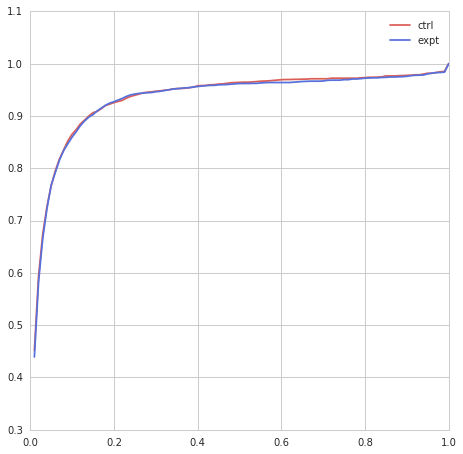

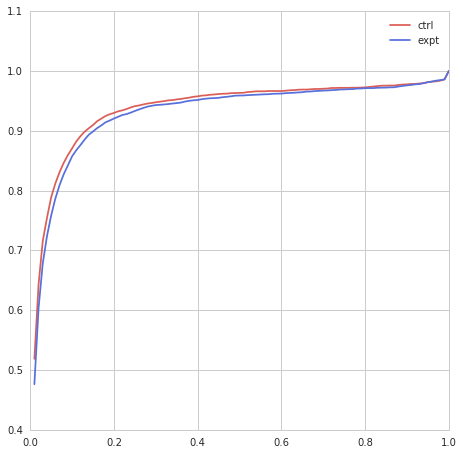

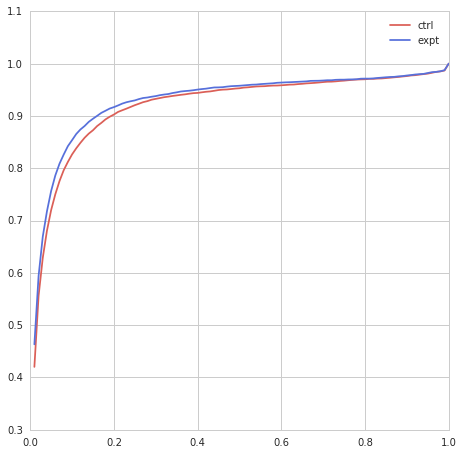

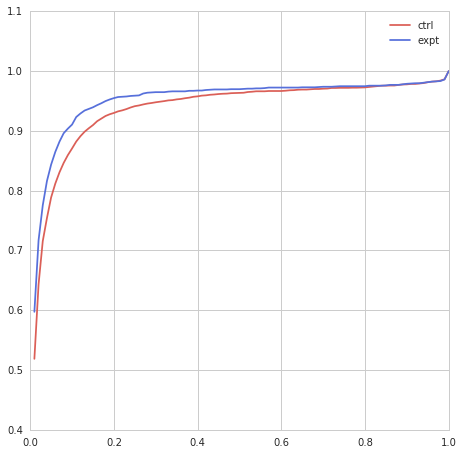

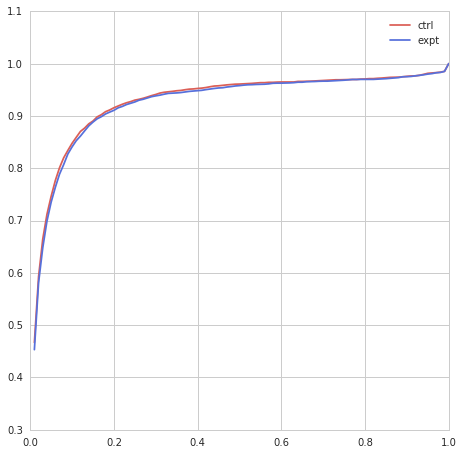

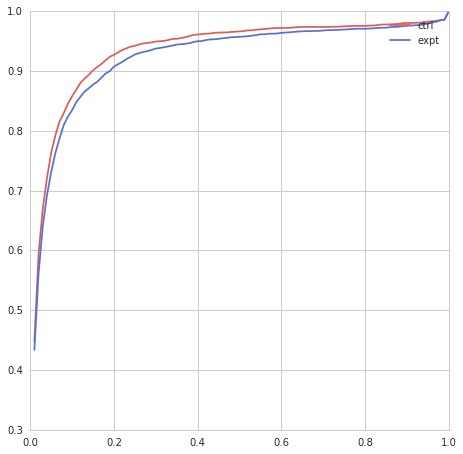

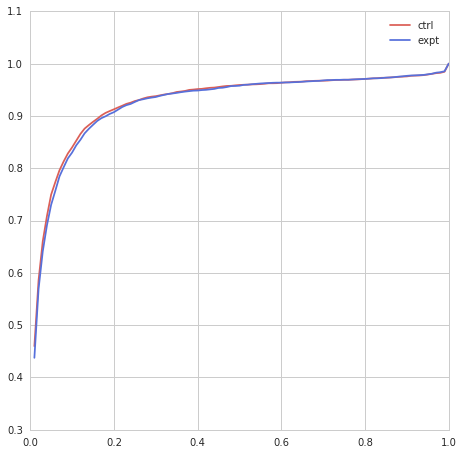

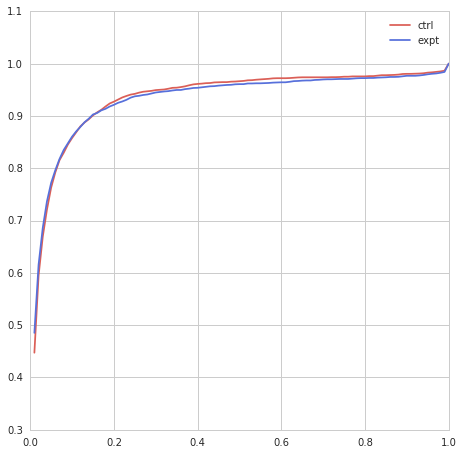

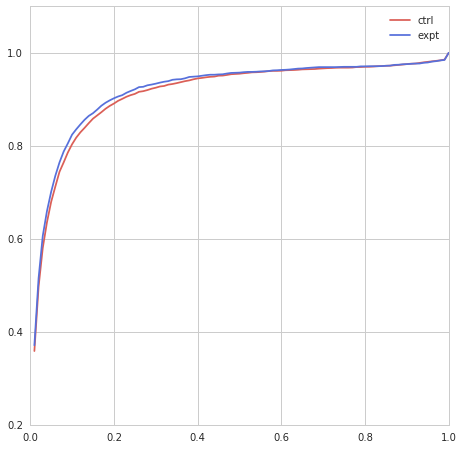

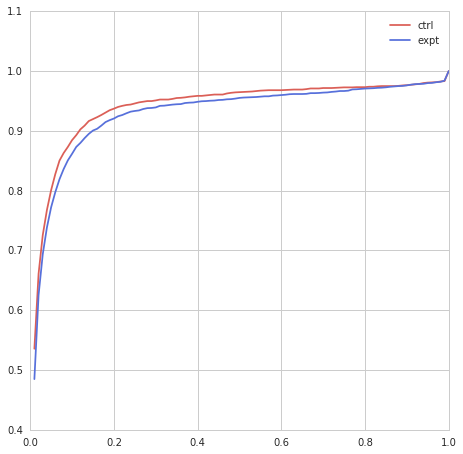

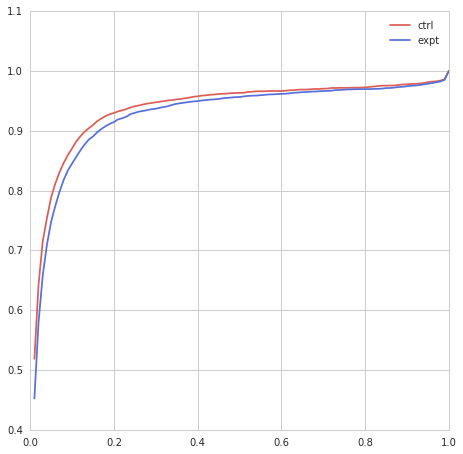

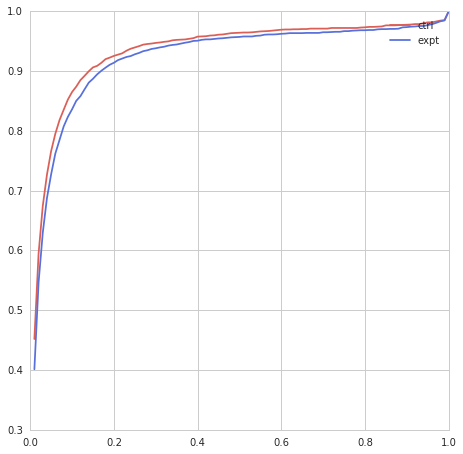

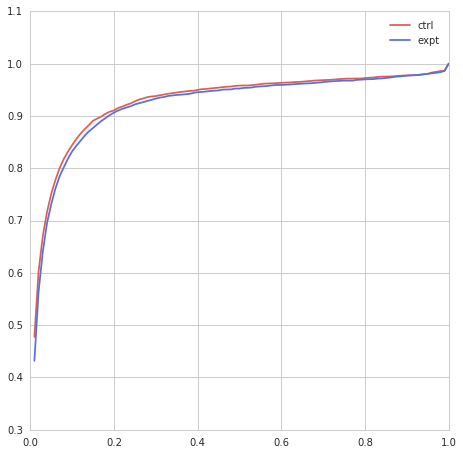

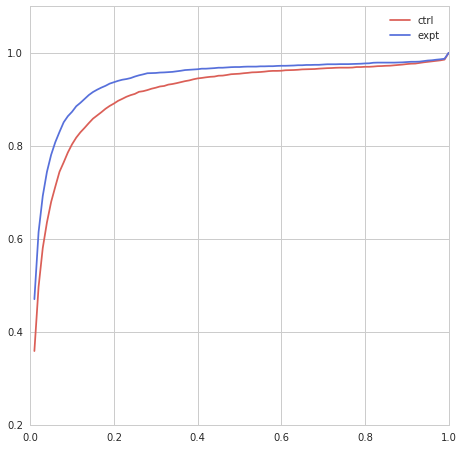

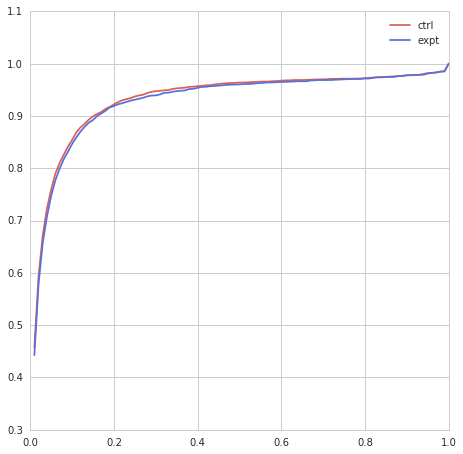

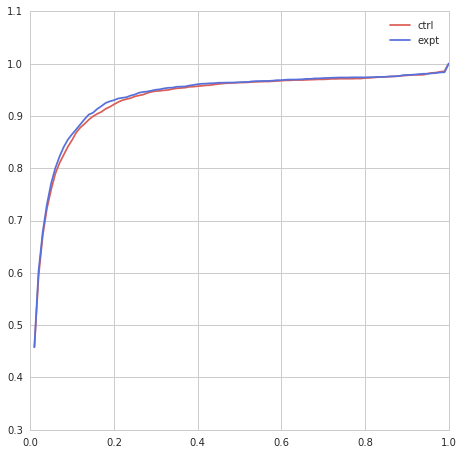

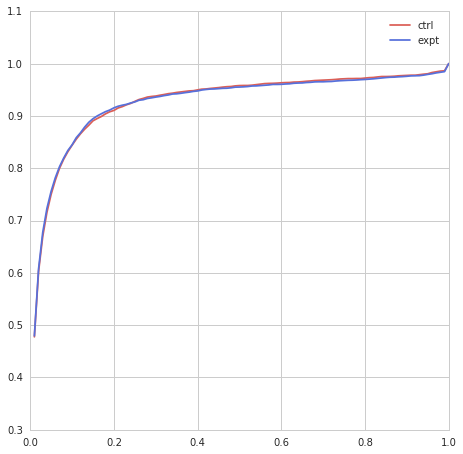

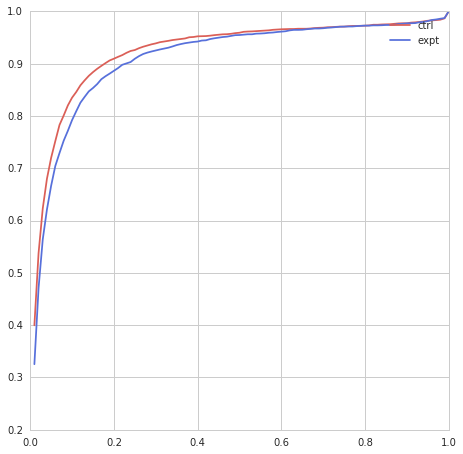

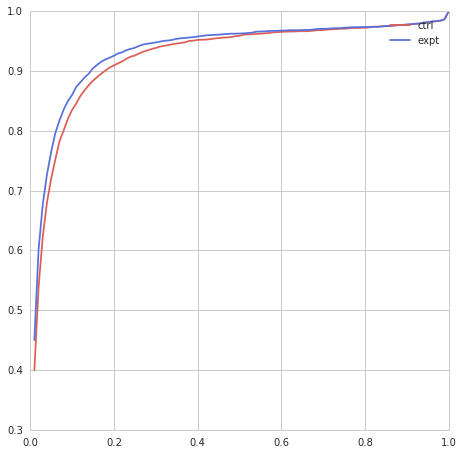

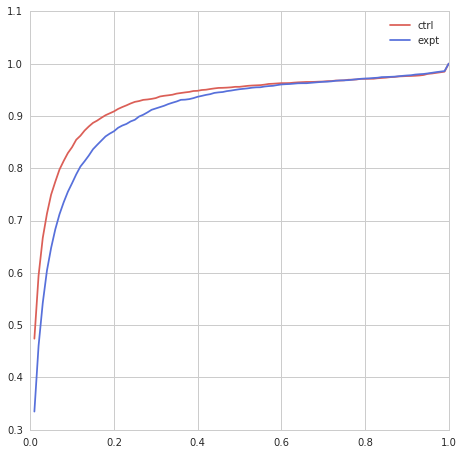

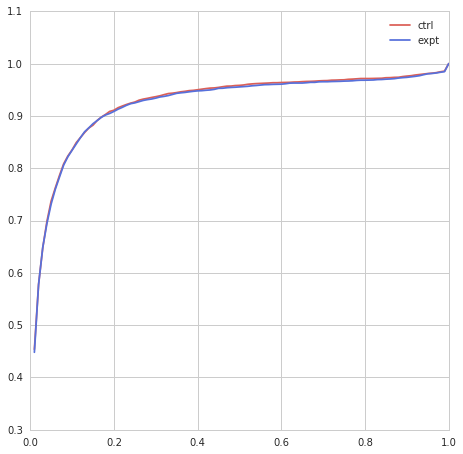

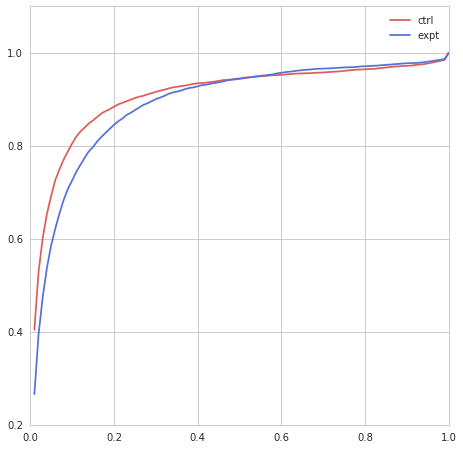

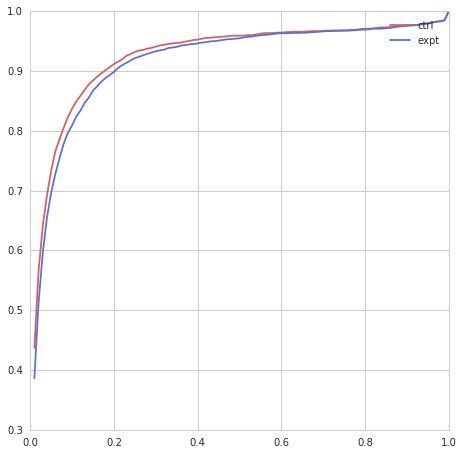

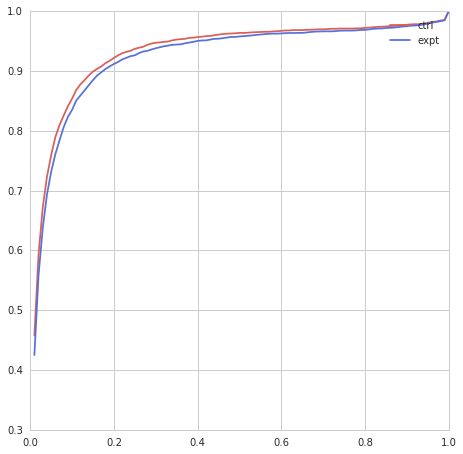

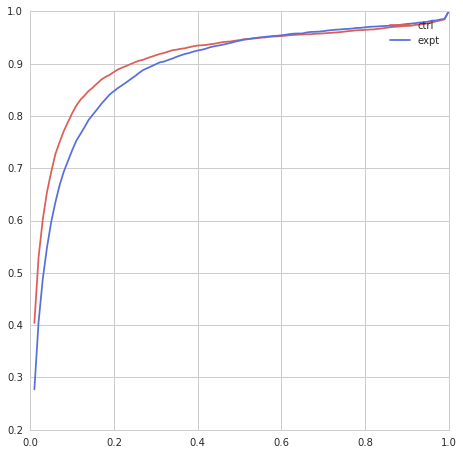

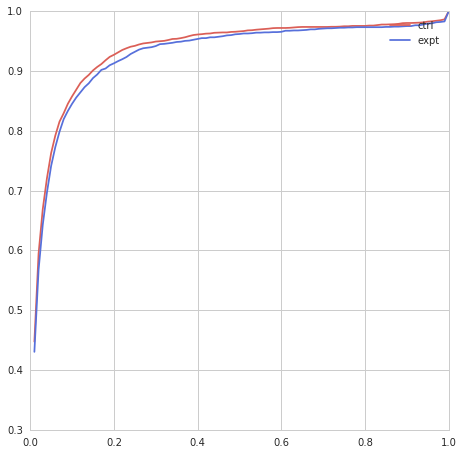

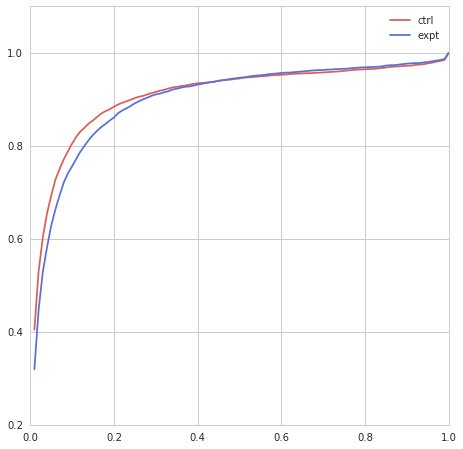

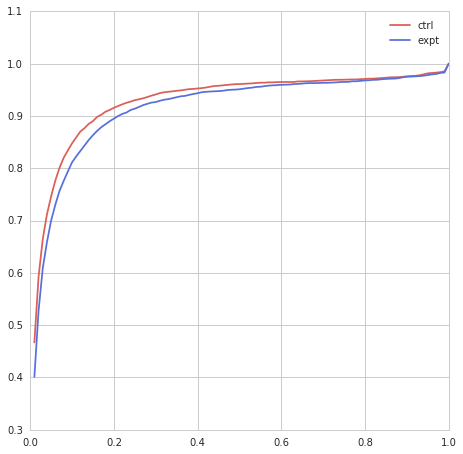

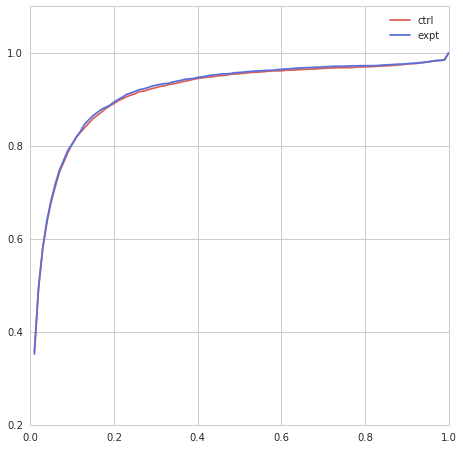

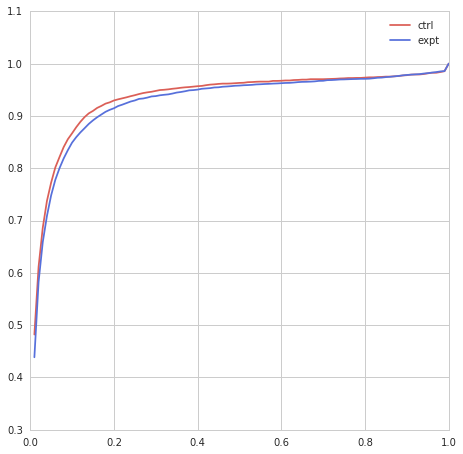

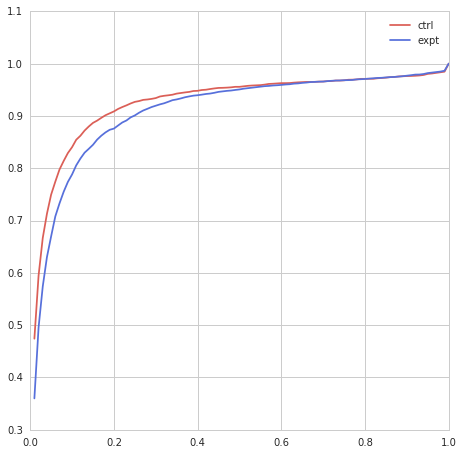

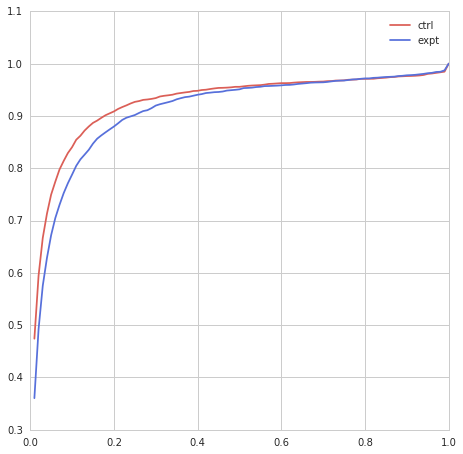

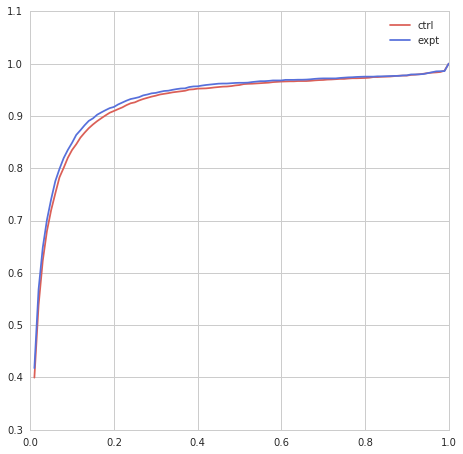

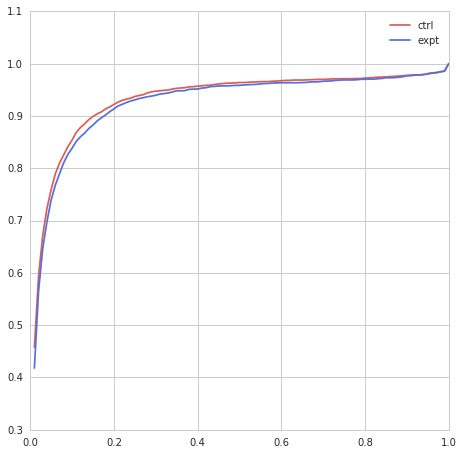

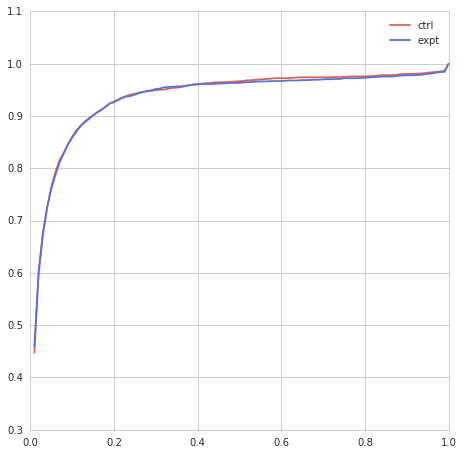

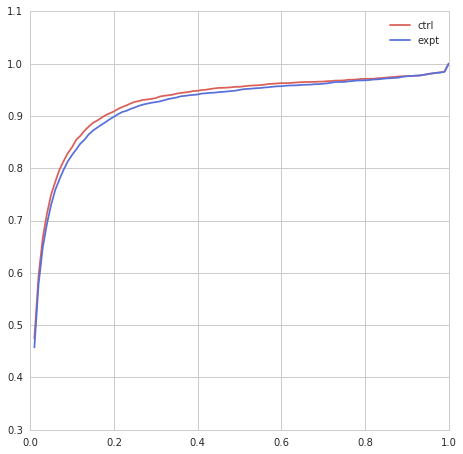

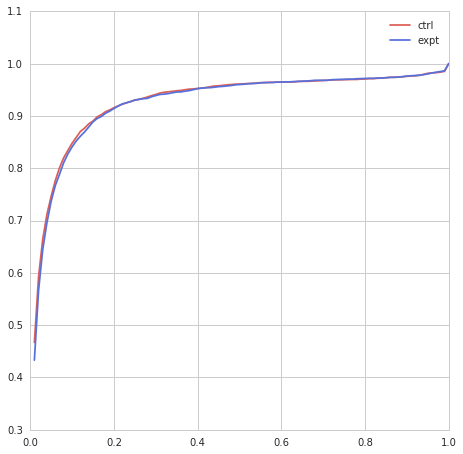

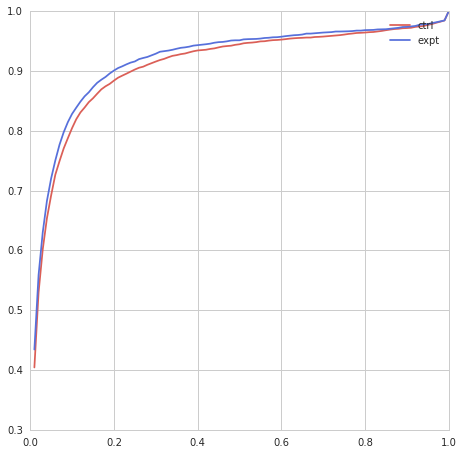

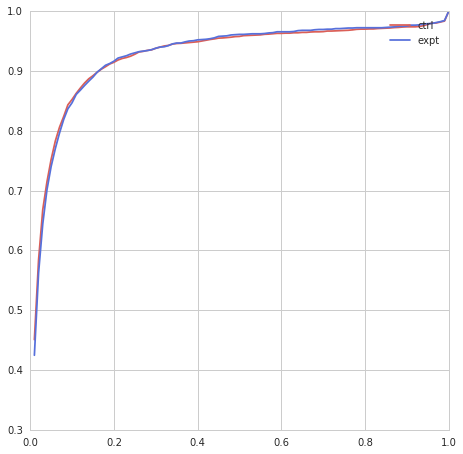

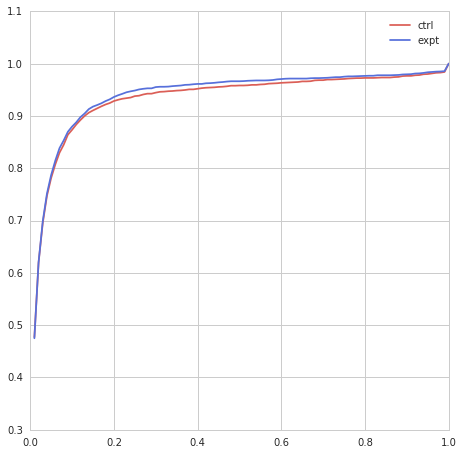

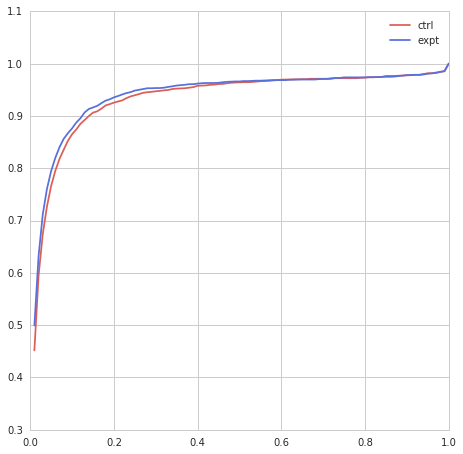

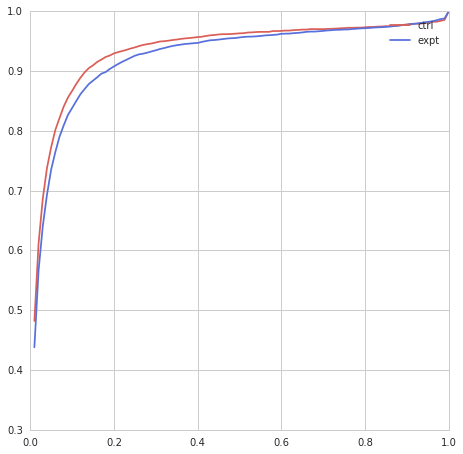

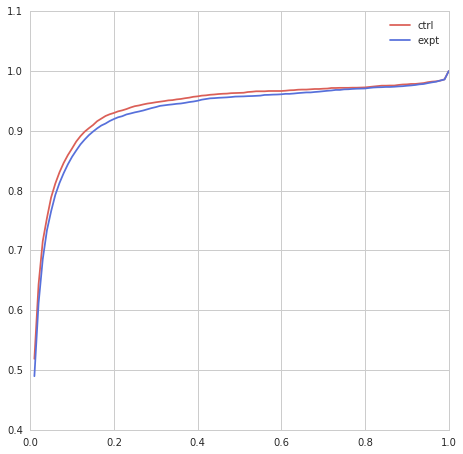

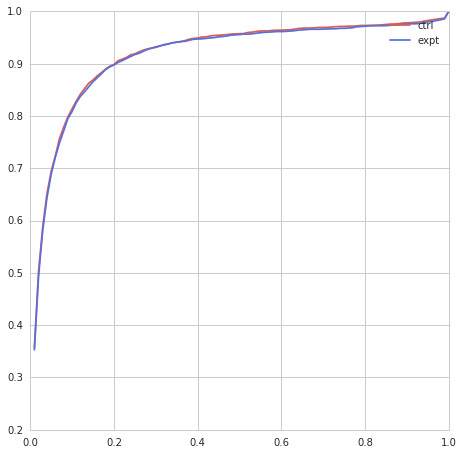

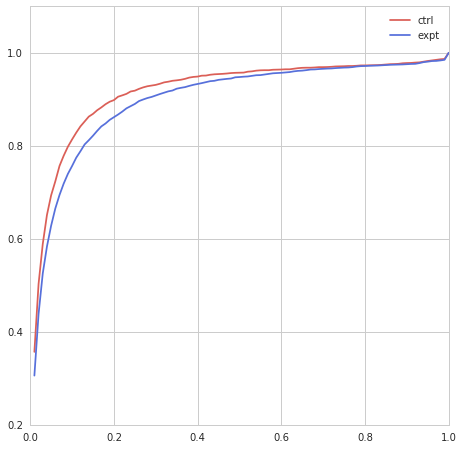

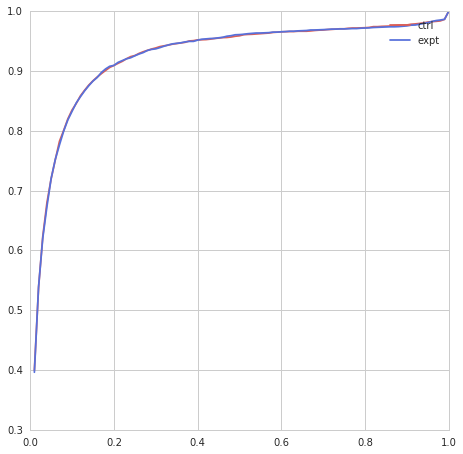

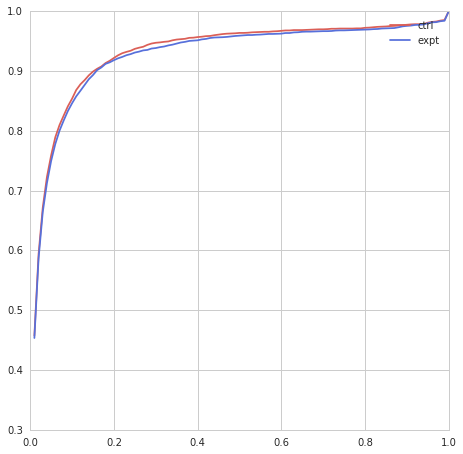

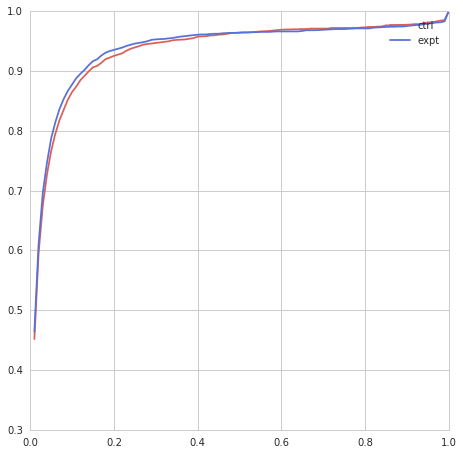

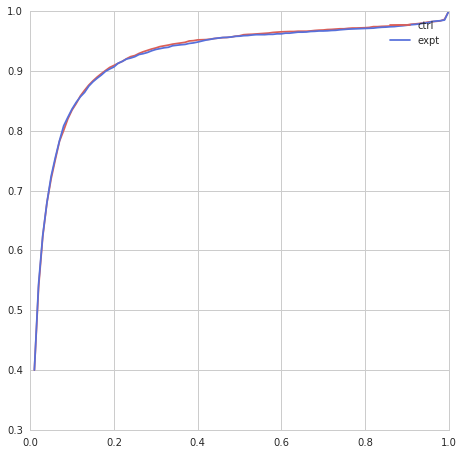

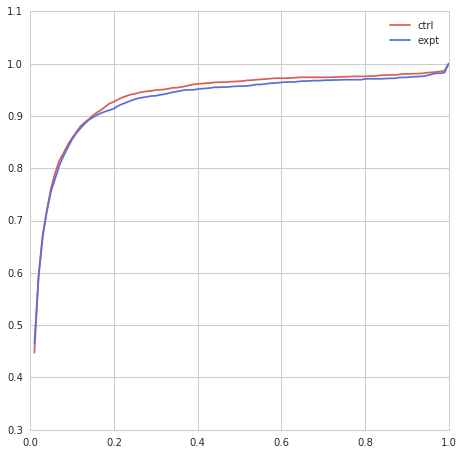

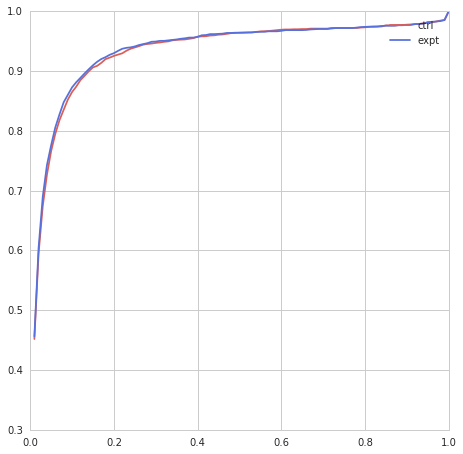

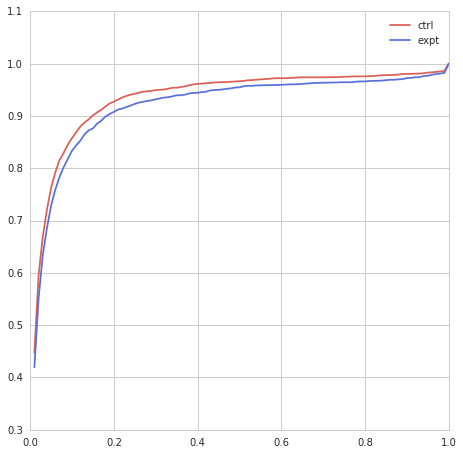

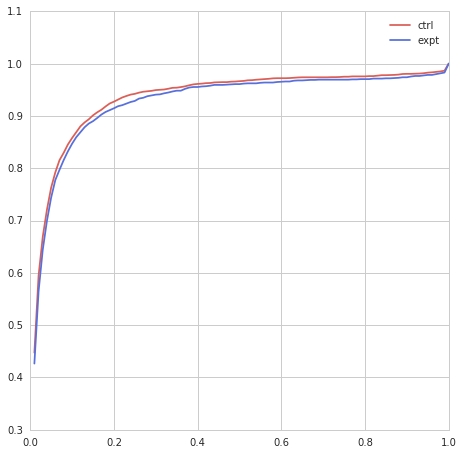

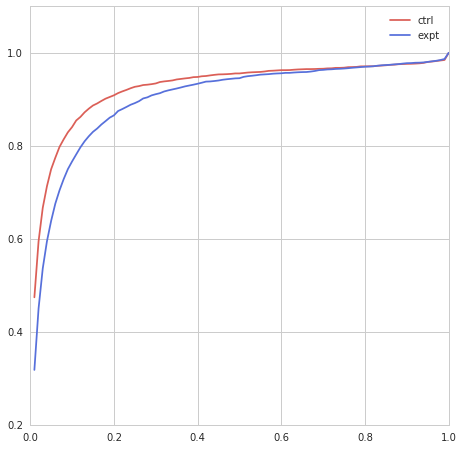

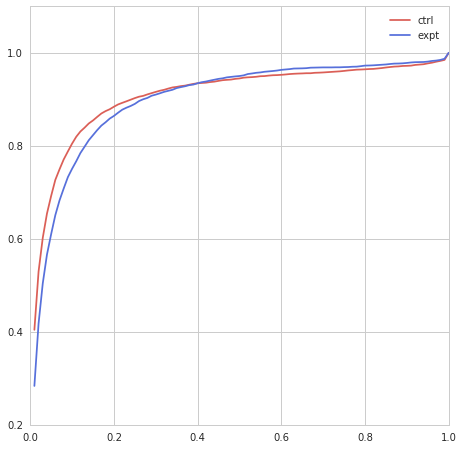

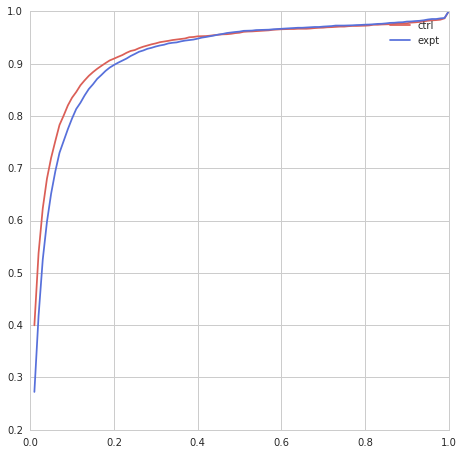

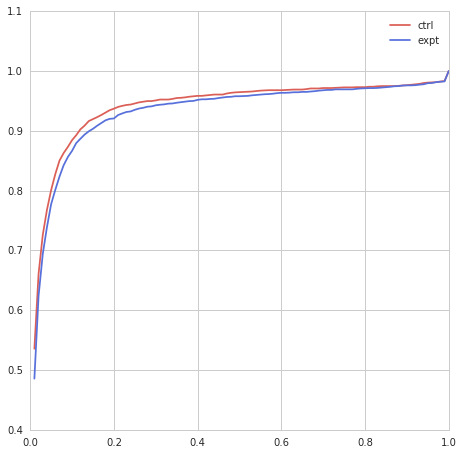

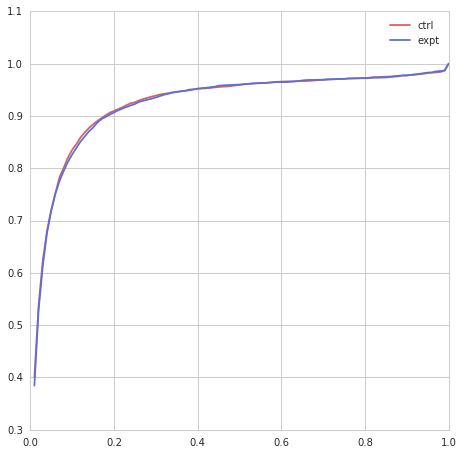

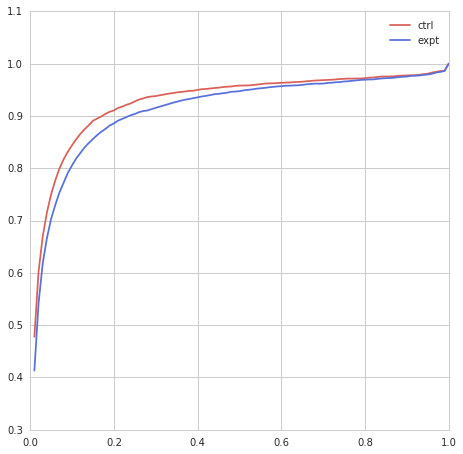

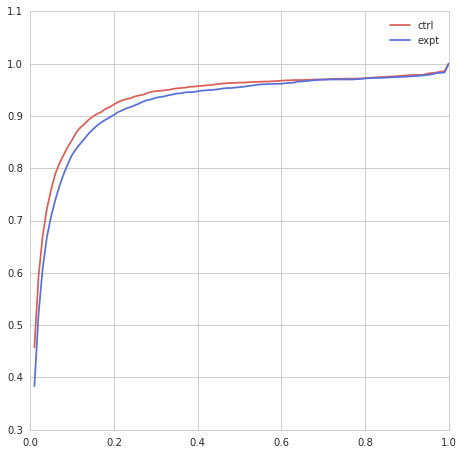

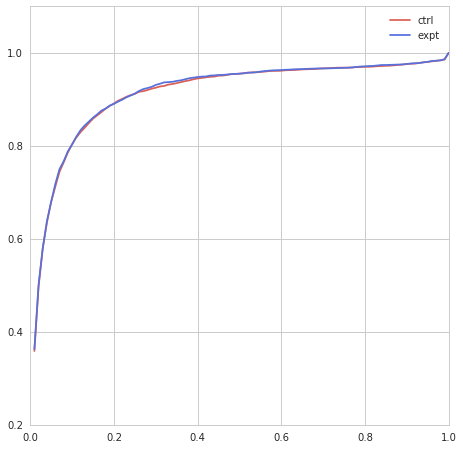

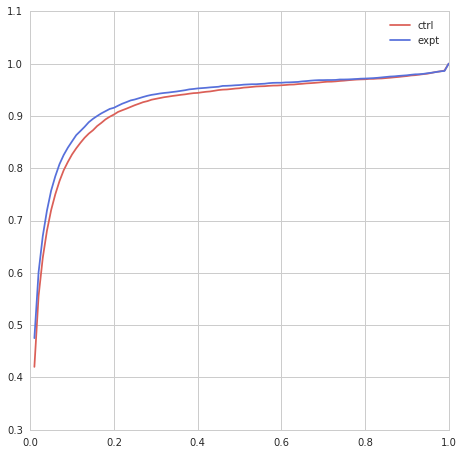

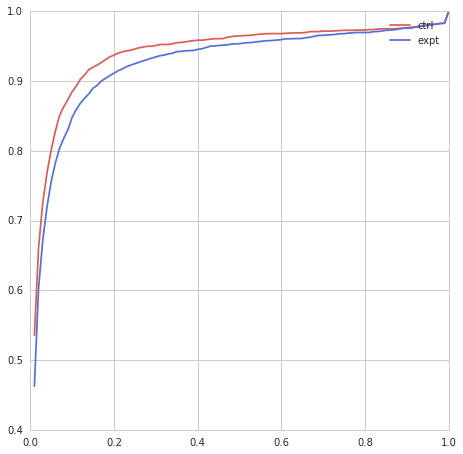

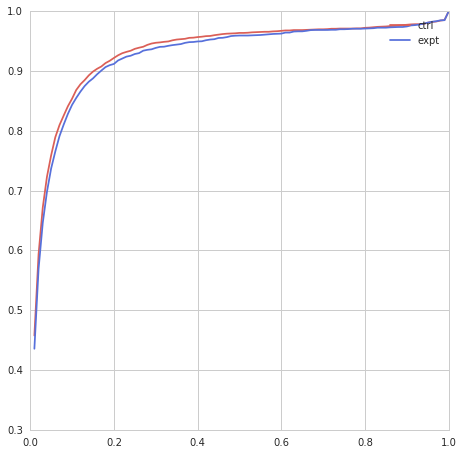

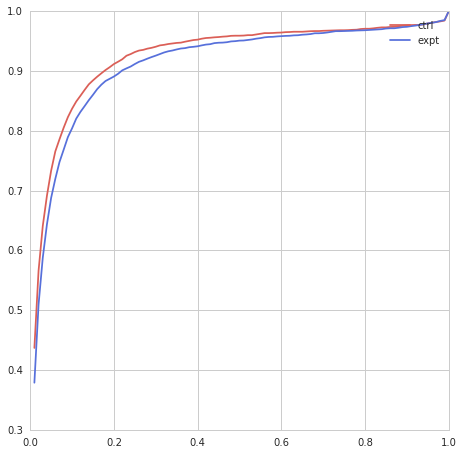

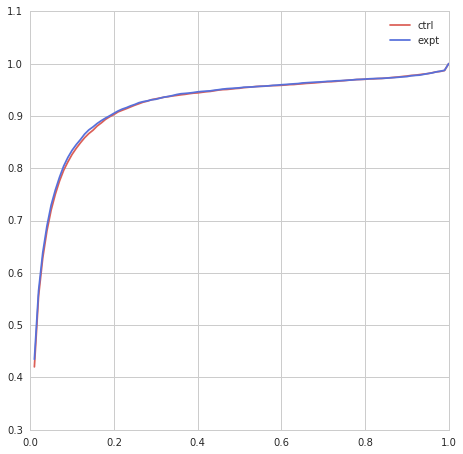

In [4]:
out_file = '/home/bay001/projects/encode/analysis/atac_intron_analysis/ks_test_CI.txt'
out_dir = '/home/bay001/projects/encode/analysis/atac_intron_analysis/cdf_plots_CI/'
jxc_dir = '/home/bay001/projects/encode/analysis/atac_intron_analysis/jxc_from_eric'
o = open(out_file, 'w')
progress = tnrange(len(k562.index))
for index in k562.index:
    
    rbp = k562.ix[index]['name']
    kd, ctrl = get_all_required_files(index,jxc_dir)
    stat, p = stats.ks_2samp(kd, ctrl)
    out_file = os.path.join(out_dir, '{}_{}_{}.png'.format(index, rbp, 'k562'))
    o.write('{}\t{}\t{}\t{}\t{}\n'.format(index, rbp, 'k562', stat, p))
    plot_cdf(kd, ctrl, out_file)
    progress.update(1)

progress = tnrange(len(hepg2.index))
for index in hepg2.index:
    try:
        rbp = hepg2.ix[index]['name']
        kd, ctrl = get_all_required_files(index,jxc_dir)
        stat, p = stats.ks_2samp(kd, ctrl)
        out_file = os.path.join(out_dir, '{}_{}_{}.png'.format(index, rbp, 'hepg2'))
        o.write('{}\t{}\t{}\t{}\t{}\n'.format(index, rbp, 'hepg2', stat, p))
        plot_cdf(kd, ctrl, out_file)
    except IOError:
        print(index)
        pass
    progress.update(1)
o.close()

In [ ]:
# check individually some of them


In [ ]:
kd, ctrl = get_all_required_files('ENCSR137HKS',jxc_dir)
plot_cdf(kd, ctrl, '~/temp.png')

In [ ]:
plt.hist(kd)

In [ ]:
plt.hist(ctrl)

# Load manifest
- contains fold enrichment info for U1/U11ATAC

In [ ]:
df = pd.read_table('/home/bay001/projects/encode/analysis/atac_intron_analysis/20170505.ALLENCODEinclnotsubmitted.txt.nopipes.txt')

In [ ]:
df.ix['RNU11'].sort_values(by='fold-enrichment', ascending=False).head()

In [ ]:
rbp = 'DKC1'
df[df['element'].str.contains(rbp)].ix['RNU11'] # .sort_values(by='fold-enrichment')

In [ ]:
df[df['element'].str.contains(rbp)].ix['RNU1'] # .sort_values(by='fold-enrichment')

In [ ]:
dx = pd.read_table('/home/bay001/projects/encode/analysis/atac_intron_analysis/ks_test.txt', names=[
    'enc','rbp','cell','statistic','p'
])
dx.sort_values(by='p')